<a href="https://colab.research.google.com/github/pepper11com/goede-wandeling-hog-detection/blob/main/Kopie_van_Meer_uit_je_Colab_abonnement_halen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title 1. Setup: Install Libraries & GPU Check
# Install supervision and Grounding DINO first from PyPI
!pip install -q supervision groundingdino-py transformers matplotlib scikit-learn pyyaml

# Verify GPU availability and PyTorch
import torch
if not torch.cuda.is_available():
    print("⚠️ WARNING: GPU not found. Inference will be slow on CPU.")
    DEVICE = "cpu"
else:
    DEVICE = "cuda"
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU found: {gpu_name}")
    print(f"   PyTorch version: {torch.__version__}")
    cuda_version = torch.version.cuda
    print(f"   PyTorch built with CUDA version: {cuda_version}")
    torch.cuda.empty_cache()

✅ GPU found: NVIDIA A100-SXM4-40GB
   PyTorch version: 2.6.0+cu124
   PyTorch built with CUDA version: 12.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title 2. Imports
import os
import csv
import cv2 # OpenCV
import torch
import supervision as sv
from groundingdino.util.inference import Model as GroundingDINOModel
from tqdm.notebook import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil # For file operations
import yaml # For data.yaml
from collections import Counter, defaultdict

warnings.filterwarnings("ignore")

In [ ]:
# @title 3. Configuration
# ----- Paths and Settings -----
# IMPORTANT: Mount Google Drive if your images are there, or upload to Colab runtime
# Example for Colab runtime folder:
IMAGE_SOURCE_DIR = "images"  # Folder containing your ~300 original images
BASE_OUTPUT_DIR = "groundingdino_yolo_dataset" # Base output directory for everything

# ----- YOLO Dataset Structure (will be created under BASE_OUTPUT_DIR) -----
YOLO_IMAGES_DIR = os.path.join(BASE_OUTPUT_DIR, "images")
YOLO_LABELS_DIR = os.path.join(BASE_OUTPUT_DIR, "labels")
ANNOTATED_IMAGES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "annotated_preview") # To save some DINO annotated images
STATS_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "stats")
OUTPUT_CSV_DINO_RAW = os.path.join(BASE_OUTPUT_DIR, "all_groundingdino_detections.csv") # Raw output from DINO

# ----- Dataset Split Ratios -----
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1 # If sum > 1, test_ratio will be adjusted. If 0, no test set.

# ----- Model Configuration (GroundingDINO) -----
# These are usually downloaded automatically by the library if not found.
# Using default names is often sufficient.
GROUNDING_DINO_CONFIG_PATH = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "groundingdino_swint_ogc.pth"

# ----- Detection Settings (GroundingDINO) -----
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25 # Can be slightly lower than box_threshold
NMS_THRESHOLD = 0.7 # Non-Max Suppression

# ----- Visualization Settings -----
NUM_IMAGES_TO_VISUALIZE = 10 # Number of images to save with DINO annotations
VIS_CONFIDENCE_THRESHOLD = 0.4 # Only show DINO boxes above this confidence in visualizations

# ----- Categories (IMPORTANT: Define your 8+ sfeerbepalende categorieën here!) -----
# Deze moeten overeenkomen met wat je met je docent hebt afgesproken.
# Gebruik beschrijvende, maar niet te complexe termen.
# Voorbeeld categorieën (pas deze aan!):
CATEGORIES = [
    "green plants", "flowers", "garbage bin",
    "historic building",
    "sign post", "person",
    "car", "bus", "bench", "lamp post",
]
print(f"✅ Configured to detect {len(CATEGORIES)} categories: {CATEGORIES}")

# Create directories
os.makedirs(IMAGE_SOURCE_DIR, exist_ok=True) # Make sure this exists for uploading
os.makedirs(YOLO_IMAGES_DIR, exist_ok=True)
os.makedirs(YOLO_LABELS_DIR, exist_ok=True)
os.makedirs(ANNOTATED_IMAGES_OUTPUT_DIR, exist_ok=True)
os.makedirs(STATS_OUTPUT_DIR, exist_ok=True)
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(YOLO_IMAGES_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_LABELS_DIR, split), exist_ok=True)

print(f"❗ Please upload your images to the '{IMAGE_SOURCE_DIR}' directory in Colab's file browser.")
print(f"Output will be in '{BASE_OUTPUT_DIR}'")

✅ Configured to detect 10 categories: ['green plants', 'flowers', 'garbage bin', 'historic building', 'sign post', 'person', 'car', 'bus', 'bench', 'lamp post']
❗ Please upload your images to the 'images' directory in Colab's file browser.
Output will be in 'groundingdino_yolo_dataset'


In [ ]:
# @title 4. Load Grounding DINO Model
# (Using your corrected download logic - this cell is mostly unchanged from your original)
import requests
import subprocess

def download_file(url, local_path):
    if not os.path.exists(local_path):
        print(f"Downloading {os.path.basename(local_path)}...")
        parent_dir = os.path.dirname(local_path)
        if parent_dir and not os.path.exists(parent_dir):
             os.makedirs(parent_dir, exist_ok=True)
        try:
            subprocess.run(['wget', '-q', '-O', local_path, url], check=True)
            print(f"Download complete: {local_path}")
        except subprocess.CalledProcessError as e:
            print(f"ERROR: Failed to download {url} using wget. Error: {e}")
            if os.path.exists(local_path): os.remove(local_path)
            raise e
    else:
        print(f"File {os.path.basename(local_path)} already exists at {local_path}.")

if not os.path.exists(GROUNDING_DINO_CONFIG_PATH):
    print(f"Config file not found. Cloning GroundingDINO repository...")
    grounding_dino_repo_dir = os.path.dirname(GROUNDING_DINO_CONFIG_PATH).split('/')[0]
    if not grounding_dino_repo_dir: grounding_dino_repo_dir = "GroundingDINO" # Default
    if not os.path.exists(grounding_dino_repo_dir):
       try:
           subprocess.run(['git', 'clone', '-q', 'https://github.com/IDEA-Research/GroundingDINO.git', grounding_dino_repo_dir], check=True)
           print("GroundingDINO repository cloned.")
           if not os.path.exists(GROUNDING_DINO_CONFIG_PATH):
               print(f"❌ ERROR: Config file still not found at {GROUNDING_DINO_CONFIG_PATH} after cloning.")
               # Attempt to find common config files if the default path is wrong after clone
               found_config = list(Path(grounding_dino_repo_dir).rglob('*SwinT_OGC.py'))
               if found_config:
                   GROUNDING_DINO_CONFIG_PATH = str(found_config[0])
                   print(f"💡 Found a config: {GROUNDING_DINO_CONFIG_PATH}")
               else:
                  raise FileNotFoundError("Could not locate a suitable DINO config file.")
       except subprocess.CalledProcessError as e:
            print(f"❌ ERROR: Failed to clone GroundingDINO repository. {e}")
            raise e
    elif not os.path.exists(GROUNDING_DINO_CONFIG_PATH):
         print(f"❌ ERROR: Directory '{grounding_dino_repo_dir}' exists, but config file not found at {GROUNDING_DINO_CONFIG_PATH}.")
         raise FileNotFoundError(f"Config file missing: {GROUNDING_DINO_CONFIG_PATH}")

CHECKPOINT_URL = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
download_file(CHECKPOINT_URL, GROUNDING_DINO_CHECKPOINT_PATH)

try:
    print("\nLoading Grounding DINO model...")
    grounding_dino_model = GroundingDINOModel(
        model_config_path=GROUNDING_DINO_CONFIG_PATH,
        model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
        device=DEVICE
    )
    print("✅ Grounding DINO model loaded successfully.")
except Exception as e:
    print(f"\n❌ Error loading Grounding DINO model: {e}")
    print("   Ensure paths are correct and checkpoint downloaded.")
    raise RuntimeError("Failed to load Grounding DINO model.")

File groundingdino_swint_ogc.pth already exists at groundingdino_swint_ogc.pth.

Loading Grounding DINO model...
final text_encoder_type: bert-base-uncased
✅ Grounding DINO model loaded successfully.


In [ ]:
# @title 5. Prepare Image List and Split Dataset
all_image_files = sorted([f for f in os.listdir(IMAGE_SOURCE_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png"))])

if not all_image_files:
    print(f"❌ No images found in {IMAGE_SOURCE_DIR}. Please upload images and restart runtime or re-run this cell.")
    # Exit or raise error if no images
    raise FileNotFoundError(f"No images found in {IMAGE_SOURCE_DIR}")
else:
    print(f"Found {len(all_image_files)} total images in {IMAGE_SOURCE_DIR}.")

    # Adjust ratios if they don't sum to 1
    if TRAIN_RATIO + VAL_RATIO + TEST_RATIO > 1.0:
        print("Warning: Ratios sum to > 1. Adjusting test_ratio.")
        TEST_RATIO = max(0, 1.0 - TRAIN_RATIO - VAL_RATIO)
    if TRAIN_RATIO + VAL_RATIO == 0 : # Avoid division by zero if only test set is desired (unlikely)
        if TEST_RATIO == 1.0 and len(all_image_files) > 0:
             train_files, val_files, test_files = [], [], all_image_files
        else:
            raise ValueError("TRAIN_RATIO and VAL_RATIO cannot both be zero unless TEST_RATIO is 1.0")
    elif TRAIN_RATIO + VAL_RATIO < 1.0 and TEST_RATIO == 0: # If only train/val and sum is less than 1
        print("Info: Train + Val ratio is < 1 and Test ratio is 0. Normalizing Train and Val.")
        current_sum = TRAIN_RATIO + VAL_RATIO
        TRAIN_RATIO = TRAIN_RATIO / current_sum
        VAL_RATIO = VAL_RATIO / current_sum


    if TEST_RATIO > 0:
        # Split into train_val and test
        train_val_files, test_files = train_test_split(all_image_files, test_size=TEST_RATIO, random_state=42)
        # Split train_val into train and val
        # Adjust val_size for the remaining part
        if len(train_val_files) > 0 : # Ensure train_val_files is not empty
            relative_val_ratio = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO) if (TRAIN_RATIO + VAL_RATIO) > 0 else 0
            if relative_val_ratio > 0 and relative_val_ratio < 1:
                 train_files, val_files = train_test_split(train_val_files, test_size=relative_val_ratio, random_state=42)
            elif relative_val_ratio == 0: # Only train, no val
                train_files = train_val_files
                val_files = []
            elif relative_val_ratio >= 1: # Only val, no train (after test split)
                train_files = []
                val_files = train_val_files
            else: # Should not happen
                train_files, val_files = train_val_files, []
        else: # No files left for train/val after test split
            train_files, val_files = [],[]

    else: # No test set
        test_files = []
        if len(all_image_files) > 0:
            relative_val_ratio = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO) if (TRAIN_RATIO + VAL_RATIO) > 0 else 0
            if relative_val_ratio > 0 and relative_val_ratio < 1:
                train_files, val_files = train_test_split(all_image_files, test_size=relative_val_ratio, random_state=42)
            elif relative_val_ratio == 0: # Only train
                train_files = all_image_files
                val_files = []
            elif relative_val_ratio >= 1: # Only val
                train_files = []
                val_files = all_image_files
            else:
                train_files, val_files = all_image_files, []
        else:
            train_files, val_files = [], []


    print(f"  Training images: {len(train_files)}")
    print(f"  Validation images: {len(val_files)}")
    print(f"  Test images: {len(test_files)}")

    # Create a dictionary to map filename to its split for easier lookup
    file_to_split = {}
    for f in train_files: file_to_split[f] = "train"
    for f in val_files: file_to_split[f] = "val"
    for f in test_files: file_to_split[f] = "test"

Found 300 total images in images.
  Training images: 209
  Validation images: 61
  Test images: 30


In [ ]:
# @title 6. Process Images: Annotate with GroundingDINO, Save YOLO Labels & Visualizations

# --- Annotators for visualization ---
box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=1, text_scale=0.5)

# --- Data collectors for stats ---
all_dino_detections_csv_rows = []
detected_classes_counts = Counter()
detections_per_image_counts = []
confidence_scores_all_detections = []

images_processed_count = 0
images_visualized_count = 0

# Process all images
for filename in tqdm(all_image_files, desc="Annotating Images"):
    if filename not in file_to_split:
        print(f"Warning: File {filename} not found in any split. Skipping.")
        continue

    current_split = file_to_split[filename]
    source_image_path = os.path.join(IMAGE_SOURCE_DIR, filename)

    yolo_image_output_path = os.path.join(YOLO_IMAGES_DIR, current_split, filename)
    yolo_label_output_path = os.path.join(YOLO_LABELS_DIR, current_split, os.path.splitext(filename)[0] + ".txt")

    try:
        image_bgr = cv2.imread(source_image_path)
        if image_bgr is None:
            print(f"⚠️ Warning: Could not read image {filename}. Skipping.")
            continue
        if image_bgr.size == 0:
            print(f"⚠️ Warning: Image {filename} is empty. Skipping.")
            continue

        img_h, img_w, _ = image_bgr.shape

        # --- Perform Inference using the standard predict_with_classes ---
        # print(f"\n--- Debugging DINO for image: {filename} ---") # Uncomment for per-image header
        # print(f"  Using CATEGORIES: {CATEGORIES}") # Uncomment
        # print(f"  Using BOX_THRESHOLD: {BOX_THRESHOLD}, TEXT_THRESHOLD: {TEXT_THRESHOLD}") # Uncomment

        detections_sv = grounding_dino_model.predict_with_classes(
            image=image_bgr,
            classes=CATEGORIES,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD  # Deze is cruciaal
        )

        # ----- DEBUGGING OUTPUT OF predict_with_classes -----
        if images_processed_count < 5 or len(detections_sv) > 0: # Print debug info for first few images or if detections found
            print(f"\n--- Debug output for image: {filename} (Split: {current_split}) ---")
            print(f"  Detections_sv object from predict_with_classes (before NMS): {detections_sv}")
            print(f"  Number of detections from predict_with_classes (before NMS): {len(detections_sv)}")
            if len(detections_sv) > 0:
                for i_debug in range(len(detections_sv)):
                    print(f"    Raw Det {i_debug}: xyxy={detections_sv.xyxy[i_debug]}, conf={detections_sv.confidence[i_debug]:.3f}, class_id={detections_sv.class_id[i_debug]}")

                # Controleer of er class_ids zijn die NIET None zijn
                non_none_cids = [cid for cid in detections_sv.class_id if cid is not None]
                if not non_none_cids:
                    print(f"    WARNING: All {len(detections_sv)} detections have class_id=None. Text threshold ({TEXT_THRESHOLD}) might be too high for class matching, or prompts are not matching well.")
                else:
                    print(f"    Found {len(non_none_cids)} detections with non-None class_ids.")
        # ----- END DEBUGGING -----


        # --- NMS ---
        if NMS_THRESHOLD is not None and NMS_THRESHOLD < 1.0 and len(detections_sv) > 0:
            detections_sv = detections_sv.with_nms(threshold=NMS_THRESHOLD)

        num_valid_detections_for_yolo = 0
        yolo_labels_for_this_image = []
        current_image_valid_class_detections_count = 0

        for i in range(len(detections_sv)):
            xyxy = detections_sv.xyxy[i]
            confidence = detections_sv.confidence[i]
            class_id_dino = detections_sv.class_id[i]

            # De cruciale check: class_id_dino mag niet None zijn voor verdere verwerking
            if class_id_dino is None:
                # print(f"  Skipping detection {i} for image {filename} because class_id is None.") # Uncomment for verbose skipping
                continue # Ga naar de volgende detectie

            if not (0 <= class_id_dino < len(CATEGORIES)): # Extra veiligheidscheck
                print(f"  WARNING: Invalid class_id {class_id_dino} encountered for image {filename}. Skipping.")
                continue

            # Als we hier komen, is class_id_dino een geldige integer index
            label_str = CATEGORIES[class_id_dino]
            x_min, y_min, x_max, y_max = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])

            all_dino_detections_csv_rows.append([
                filename, current_split, label_str, f"{confidence:.4f}",
                x_min, y_min, x_max, y_max
            ])

            detected_classes_counts[label_str] += 1
            confidence_scores_all_detections.append(confidence)
            current_image_valid_class_detections_count +=1

            # ... (rest van YOLO conversie)
            x_min_c = max(0, x_min)
            y_min_c = max(0, y_min)
            x_max_c = min(img_w, x_max)
            y_max_c = min(img_h, y_max)

            if x_min_c >= x_max_c or y_min_c >= y_max_c:
                continue

            dw = 1.0 / img_w
            dh = 1.0 / img_h
            x_center = (x_min_c + x_max_c) / 2.0
            y_center = (y_min_c + y_max_c) / 2.0
            w_box = x_max_c - x_min_c
            h_box = y_max_c - y_min_c

            x_center_norm = np.clip(x_center * dw, 0.0, 1.0)
            y_center_norm = np.clip(y_center * dh, 0.0, 1.0)
            w_norm = np.clip(w_box * dw, 0.0, 1.0)
            h_norm = np.clip(h_box * dh, 0.0, 1.0)

            yolo_labels_for_this_image.append(f"{class_id_dino} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f}")
            num_valid_detections_for_yolo += 1

        detections_per_image_counts.append(current_image_valid_class_detections_count)

        if num_valid_detections_for_yolo > 0:
            with open(yolo_label_output_path, "w") as f_label:
                f_label.write("\n".join(yolo_labels_for_this_image))

        # ... (Visualisatie code - deze zou nu moeten werken als class_id_dino geldig is) ...
        if images_visualized_count < NUM_IMAGES_TO_VISUALIZE and len(detections_sv) > 0:
            valid_vis_xyxy = []
            valid_vis_confidence = []
            vis_labels_list = []

            for i_vis in range(len(detections_sv)):
                conf_vis = detections_sv.confidence[i_vis]
                cid_vis = detections_sv.class_id[i_vis]  # Kan hier nog steeds None zijn als NMS het niet filtert

                if cid_vis is None: # Expliciet skippen voor visualisatie als class_id None is
                    continue

                xyxy_box_vis = detections_sv.xyxy[i_vis]

                if conf_vis >= VIS_CONFIDENCE_THRESHOLD:
                    if 0 <= cid_vis < len(CATEGORIES): # cid_vis is hier GEEN None meer
                        valid_vis_xyxy.append(xyxy_box_vis)
                        valid_vis_confidence.append(conf_vis)
                        vis_labels_list.append(f"{CATEGORIES[cid_vis]} {conf_vis:.2f}")

            if valid_vis_xyxy:
                vis_detections_for_plot = sv.Detections(
                    xyxy=np.array(valid_vis_xyxy),
                    confidence=np.array(valid_vis_confidence)
                    # class_id is niet strikt nodig voor BoxAnnotator als labels worden meegegeven
                )

                if len(vis_detections_for_plot) > 0:
                    annotated_frame = box_annotator.annotate(
                        scene=image_bgr.copy(),
                        detections=vis_detections_for_plot,
                        labels=vis_labels_list
                    )
                    annotated_image_filename = f"dino_annotated_{filename}"
                    cv2.imwrite(os.path.join(ANNOTATED_IMAGES_OUTPUT_DIR, annotated_image_filename), annotated_frame)
                    images_visualized_count += 1

        images_processed_count +=1

    except KeyboardInterrupt: # Zorg dat KeyboardInterrupt de loop stopt
        print("Interrupted by user.")
        raise # Her-raise de interrupt om de tqdm loop te stoppen
    except Exception as e:
        print(f"❌ Error processing image {filename}: {e}")
        import traceback
        traceback.print_exc()
        detections_per_image_counts.append(0)


# ... (rest van Cell 6: image copying, stats etc.) ...
# --- Copy ALL source images to their respective YOLO image split folders ---
print("\nCopying all source images to their respective YOLO split image folders...")
for fname, fsplit in tqdm(file_to_split.items(), desc="Copying images to splits"):
    src_path = os.path.join(IMAGE_SOURCE_DIR, fname)
    dst_path = os.path.join(YOLO_IMAGES_DIR, fsplit, fname)
    if os.path.exists(src_path) and not os.path.exists(dst_path):
        shutil.copy(src_path, dst_path)

print(f"\n✅ Processed {images_processed_count}/{len(all_image_files)} images.")
if images_visualized_count > 0:
    print(f"✅ Saved {images_visualized_count} sample annotated images to '{ANNOTATED_IMAGES_OUTPUT_DIR}'.")
else:
    print(f"⚠️ No images were saved with DINO annotations. Check VIS_CONFIDENCE_THRESHOLD ({VIS_CONFIDENCE_THRESHOLD}) or if DINO assigned valid class_ids.")

Annotating Images:   0%|          | 0/300 [00:00<?, ?it/s]

Streaminguitvoer ingekort tot de laatste 5000 regels.
    Found 9 detections with non-None class_ids.

--- Debug output for image: 20250415_143237.jpg (Split: val) ---
  Detections_sv object from predict_with_classes (before NMS): Detections(xyxy=array([[     1405.9,      3018.8,      2996.7,      3996.5],
       [     2.6827,      2943.9,      1221.1,        3995],
       [     1185.2,      2114.8,      1340.6,      3790.2],
       [     116.47,      474.76,      865.59,      3989.7],
       [     2538.5,      2512.6,      2864.3,        2716],
       [     2878.4,      2871.9,      2999.4,      3021.2],
       [     2284.8,      2563.4,      2491.9,      2822.4],
       [     11.478,      1494.1,      2797.3,      2717.5]], dtype=float32), mask=None, confidence=array([    0.70893,     0.62284,     0.46128,     0.70307,     0.35893,     0.37816,     0.37917,     0.64482], dtype=float32), class_id=array([6, 6, 4, 9, 6, 8, 2, 3]), tracker_id=None)
  Number of detections from predict_wit

Copying images to splits:   0%|          | 0/300 [00:00<?, ?it/s]


✅ Processed 300/300 images.
✅ Saved 10 sample annotated images to 'groundingdino_yolo_dataset/annotated_preview'.


In [ ]:
# @title 7. Save Raw DINO Detections to CSV
if all_dino_detections_csv_rows:
    try:
        with open(OUTPUT_CSV_DINO_RAW, "w", newline="", encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(["filename", "split", "dino_label", "dino_confidence", "x_min", "y_min", "x_max", "y_max"])
            writer.writerows(all_dino_detections_csv_rows)
        print(f"\n✅ Saved {len(all_dino_detections_csv_rows)} raw GroundingDINO detections to {OUTPUT_CSV_DINO_RAW}")
    except Exception as e:
         print(f"\n❌ Error writing DINO CSV file {OUTPUT_CSV_DINO_RAW}: {e}")
else:
    print("\n--- No DINO detections recorded. CSV not created. ---")


✅ Saved 3118 raw GroundingDINO detections to groundingdino_yolo_dataset/all_groundingdino_detections.csv


In [ ]:
# @title 8. Create data.yaml for YOLOv8
# Create data.yaml
data_yaml = {
    'path': os.path.abspath(BASE_OUTPUT_DIR), # Absolute path to dataset root
    'train': os.path.join('images', 'train'),  # Relative path from 'path'
    'val': os.path.join('images', 'val'),      # Relative path from 'path'
    'test': os.path.join('images', 'test') if TEST_RATIO > 0 and len(test_files) > 0 else '', # Optional
    'names': {i: name for i, name in enumerate(CATEGORIES)} # Class names
}

# Remove test key if no test images
if not data_yaml['test']:
    del data_yaml['test']

data_yaml_path = os.path.join(BASE_OUTPUT_DIR, "data.yaml")
try:
    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, sort_keys=False, default_flow_style=False)
    print(f"✅ Created YOLOv8 'data.yaml' at: {data_yaml_path}")
    print("\nContent of data.yaml:")
    with open(data_yaml_path, 'r') as f:
      print(f.read())
except Exception as e:
    print(f"❌ Error creating data.yaml: {e}")

✅ Created YOLOv8 'data.yaml' at: groundingdino_yolo_dataset/data.yaml

Content of data.yaml:
path: /content/groundingdino_yolo_dataset
train: images/train
val: images/val
test: images/test
names:
  0: green plants
  1: flowers
  2: garbage bin
  3: historic building
  4: sign post
  5: person
  6: car
  7: bus
  8: bench
  9: lamp post




--- Statistics of GroundingDINO Annotations ---

1. Distribution of Detected Classes (Top 20):
  - person: 950
  - car: 775
  - lamp post: 327
  - historic building: 276
  - garbage bin: 225
  - green plants: 161
  - sign post: 139
  - bench: 101
  - bus: 87
  - flowers: 77


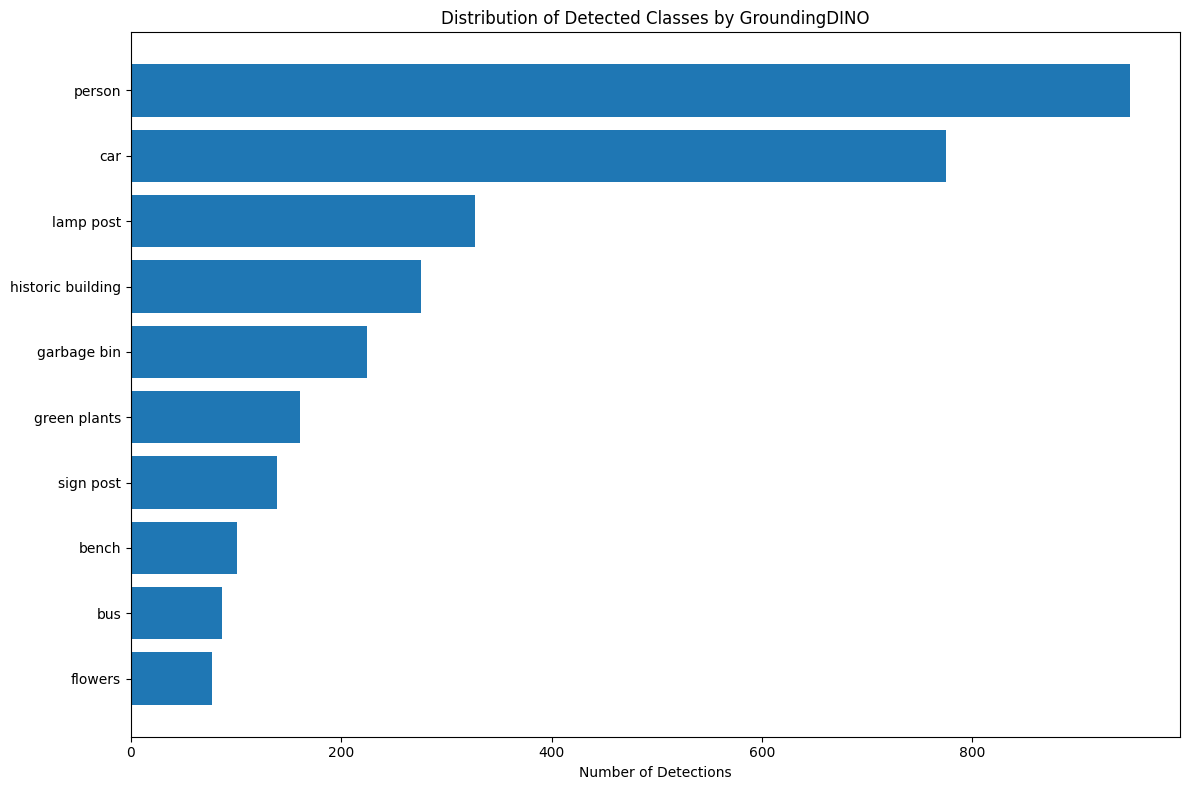


2. Detections per Image (Average: 10.39, Max: 32)


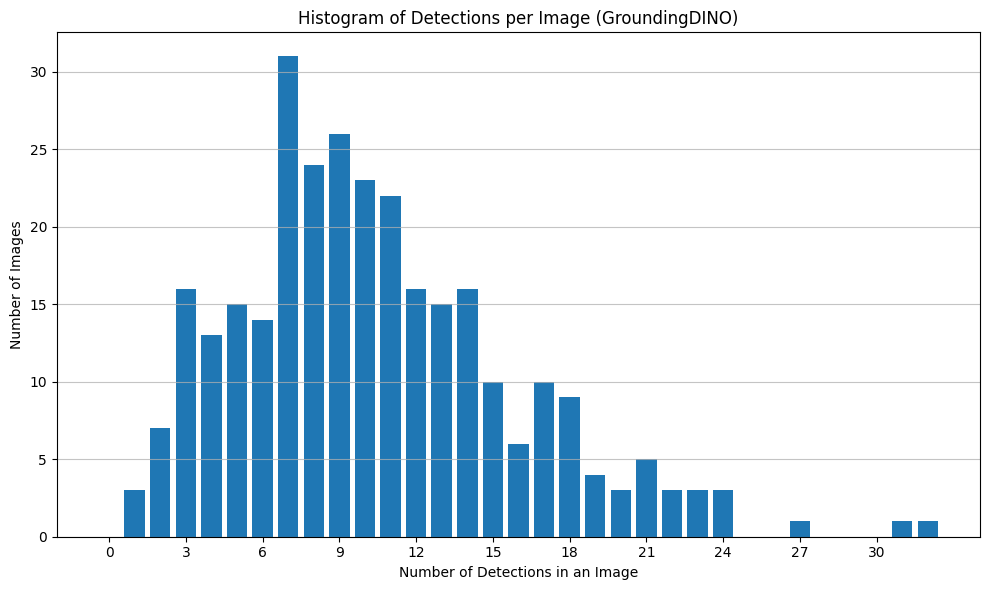


3. Confidence Scores (Average: 0.49)


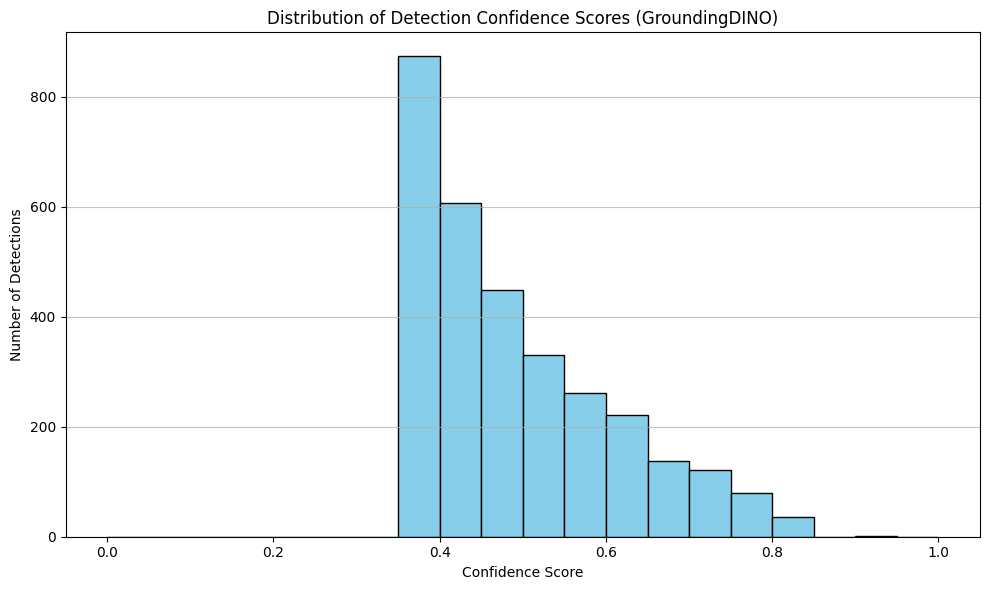

In [ ]:
# @title 9. Generate and Display Statistics & Graphs
print("\n--- Statistics of GroundingDINO Annotations ---")

# 1. Distribution of detected classes
if detected_classes_counts:
    print("\n1. Distribution of Detected Classes (Top 20):")
    for item, count in detected_classes_counts.most_common(20):
        print(f"  - {item}: {count}")

    plt.figure(figsize=(12, max(8, len(detected_classes_counts) * 0.3)))
    sorted_counts = detected_classes_counts.most_common()
    names = [item[0] for item in sorted_counts]
    values = [item[1] for item in sorted_counts]
    y_pos = np.arange(len(names))
    plt.barh(y_pos, values, align='center')
    plt.yticks(y_pos, names)
    plt.gca().invert_yaxis() # Highest bar at the top
    plt.xlabel("Number of Detections")
    plt.title("Distribution of Detected Classes by GroundingDINO")
    plt.tight_layout()
    plt.savefig(os.path.join(STATS_OUTPUT_DIR, "class_distribution.png"))
    plt.show()
else:
    print("\n1. No classes detected by GroundingDINO.")

# 2. Number of detections per image
if detections_per_image_counts:
    print(f"\n2. Detections per Image (Average: {np.mean(detections_per_image_counts):.2f}, Max: {np.max(detections_per_image_counts)})")
    plt.figure(figsize=(10, 6))
    plt.hist(detections_per_image_counts, bins=range(0, max(detections_per_image_counts) + 2), align='left', rwidth=0.8)
    plt.xlabel("Number of Detections in an Image")
    plt.ylabel("Number of Images")
    plt.title("Histogram of Detections per Image (GroundingDINO)")
    plt.xticks(range(0, max(detections_per_image_counts) + 1, max(1, (max(detections_per_image_counts)+1)//10))) # Adjust tick step
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.savefig(os.path.join(STATS_OUTPUT_DIR, "detections_per_image_histogram.png"))
    plt.show()
else:
    print("\n2. No images had detections.")


# 3. Distribution of confidence scores
if confidence_scores_all_detections:
    print(f"\n3. Confidence Scores (Average: {np.mean(confidence_scores_all_detections):.2f})")
    plt.figure(figsize=(10, 6))
    plt.hist(confidence_scores_all_detections, bins=20, range=(0,1), color='skyblue', edgecolor='black')
    plt.xlabel("Confidence Score")
    plt.ylabel("Number of Detections")
    plt.title("Distribution of Detection Confidence Scores (GroundingDINO)")
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.savefig(os.path.join(STATS_OUTPUT_DIR, "confidence_distribution.png"))
    plt.show()
else:
    print("\n3. No confidence scores recorded (no detections).")

In [ ]:
# @title Stap 2.1: Installatie en Setup YOLOv8
!pip install -q ultralytics
import ultralytics
ultralytics.checks() # Controleert of alles goed is geïnstalleerd

from ultralytics import YOLO
import os
import yaml # Om data.yaml te laden en te inspecteren
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import Image, display # Voor het tonen van afbeeldingen in Colab
import pandas as pd # Voor het maken van de tabel
from tqdm.notebook import tqdm # Voor progress bars

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 46.1/235.7 GB disk)


In [ ]:
# @title Stap 2.2: Controleer data.yaml en Definieer Trainingsparameters (AANGEPAST)
import os
import yaml

# Pad naar je data.yaml bestand (pas aan indien nodig als je het niet in Colab /content/ hebt gezet)
# Als je de 'groundingdino_yolo_dataset' map direct in /content hebt gezet:
DATA_YAML_PATH = 'groundingdino_yolo_dataset/data.yaml' # Relatief pad in Colab, wordt /content/groundingdino_yolo_dataset/data.yaml
ABSOLUTE_DATA_YAML_PATH = os.path.abspath(DATA_YAML_PATH)

# Dit is de verwachte absolute root directory van je dataset in de Colab omgeving
EXPECTED_ABS_DATASET_ROOT = os.path.abspath('groundingdino_yolo_dataset')

print(f"Verwachte absolute pad naar data.yaml: {ABSOLUTE_DATA_YAML_PATH}")
print(f"Verwachte absolute root van dataset: {EXPECTED_ABS_DATASET_ROOT}")


# Controleer of data.yaml bestaat en lees de configuratie
if not os.path.exists(ABSOLUTE_DATA_YAML_PATH):
    print(f"❌ FOUT: data.yaml niet gevonden op {ABSOLUTE_DATA_YAML_PATH}. Upload de dataset of pas het pad aan.")
    raise FileNotFoundError(f"data.yaml niet gevonden op {ABSOLUTE_DATA_YAML_PATH}")
else:
    with open(ABSOLUTE_DATA_YAML_PATH, 'r') as f:
        data_config = yaml.safe_load(f)
    print("\n✅ data.yaml geladen. Originele configuratie van bestand:")
    print(data_config)

    # Controleer en update het 'path' veld in data_config als het niet overeenkomt
    # met de verwachte absolute root in Colab.
    path_in_yaml = data_config.get('path')
    needs_update = False
    if not path_in_yaml:
        print(f"ℹ️ 'path' veld ontbreekt in data.yaml. Wordt ingesteld op: {EXPECTED_ABS_DATASET_ROOT}")
        data_config['path'] = EXPECTED_ABS_DATASET_ROOT
        needs_update = True
    elif os.path.abspath(path_in_yaml) != EXPECTED_ABS_DATASET_ROOT:
        # Dit is het geval als 'path' in yaml bijvoorbeeld '.' is, of een ander relatief pad
        # of een verkeerd absoluut pad.
        print(f"ℹ️ 'path' veld in data.yaml ('{path_in_yaml}') wijst niet naar de verwachte absolute root '{EXPECTED_ABS_DATASET_ROOT}'.")
        print(f"   Wordt geüpdatet naar: {EXPECTED_ABS_DATASET_ROOT}")
        data_config['path'] = EXPECTED_ABS_DATASET_ROOT
        needs_update = True

    if needs_update:
        # Optioneel: Schrijf de geüpdatete data.yaml terug naar schijf
        # Dit is meestal niet nodig als je het data_config dict direct aan model.train() geeft,
        # maar als YOLOv8 strikt het bestand leest, kan dit helpen.
        # Echter, de 'data' parameter van model.train() kan een pad naar een yaml *of* een dict zijn.
        # Laten we voor nu het bestand niet overschrijven en vertrouwen op het doorgeven van het pad.
        print("   (Het data.yaml bestand op schijf wordt NIET aangepast, de Python dict 'data_config' wel voor intern gebruik indien nodig)")
        # Als je het bestand WEL wilt updaten:
        # with open(ABSOLUTE_DATA_YAML_PATH, 'w') as f:
        #     yaml.dump(data_config, f, sort_keys=False, default_flow_style=False)
        # print(f"   ✅ data.yaml op schijf geüpdatet met correct pad.")
        pass

    print("\nDefinitieve data_config die gebruikt wordt (kan afwijken van bestand als 'path' is aangepast in Python dict):")
    print(data_config)


# Trainingsparameters (blijven hetzelfde)
MODEL_VARIANT = 'yolov8s.pt'
EPOCHS = 75
IMG_SIZE = 640
BATCH_SIZE = 8
EXPERIMENT_NAME = 'yolov8_amsterdam_sfeer_v1'

print(f"\nTrainingsparameters:")
print(f"  Model Variant: {MODEL_VARIANT}")
print(f"  Epochs: {EPOCHS}")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Experiment Naam: {EXPERIMENT_NAME}")

Verwachte absolute pad naar data.yaml: /content/groundingdino_yolo_dataset/data.yaml
Verwachte absolute root van dataset: /content/groundingdino_yolo_dataset

✅ data.yaml geladen. Originele configuratie van bestand:
{'path': '/content/groundingdino_yolo_dataset', 'train': 'images/train', 'val': 'images/val', 'test': 'images/test', 'names': {0: 'green plants', 1: 'flowers', 2: 'garbage bin', 3: 'historic building', 4: 'sign post', 5: 'person', 6: 'car', 7: 'bus', 8: 'bench', 9: 'lamp post'}}

Definitieve data_config die gebruikt wordt (kan afwijken van bestand als 'path' is aangepast in Python dict):
{'path': '/content/groundingdino_yolo_dataset', 'train': 'images/train', 'val': 'images/val', 'test': 'images/test', 'names': {0: 'green plants', 1: 'flowers', 2: 'garbage bin', 3: 'historic building', 4: 'sign post', 5: 'person', 6: 'car', 7: 'bus', 8: 'bench', 9: 'lamp post'}}

Trainingsparameters:
  Model Variant: yolov8s.pt
  Epochs: 75
  Image Size: 640
  Batch Size: 8
  Experiment Naa

In [ ]:
# @title Stap 2.3: Start de YOLOv8 Training
# Laad een pre-trained model
model = YOLO(MODEL_VARIANT)

print(f"\nStart training met {MODEL_VARIANT} op {DATA_YAML_PATH}...")

# Train het model
# De 'project' parameter bepaalt de hoofdmap voor runs, 'name' is de specifieke run submap.
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    project='runs/detect',  # YOLOv8 standaard projectmap
    name=EXPERIMENT_NAME,
    patience=20, # Early stopping patience: stop als er X epochs geen verbetering is in mAP50-95
    exist_ok=False # Fout als de experimentmap al bestaat (om overschrijven te voorkomen)
                   # Zet op True als je een run wilt hervatten of overschrijven (met voorzichtigheid)
)

# Na training, zoek de directory van de voltooide run
# De 'results' object van model.train() bevat niet direct het pad,
# maar YOLO slaat het op in 'runs/detect/EXPERIMENT_NAME' (of EXPERIMENT_NAME2 etc. als het al bestond)
# We proberen de exacte run directory te vinden.
# De trainer object in results kan het pad bevatten:
LATEST_RUN_DIR = str(results.save_dir) # results.save_dir is een Path object

print(f"\n✅ Training voltooid! Resultaten opgeslagen in: {LATEST_RUN_DIR}")


Start training met yolov8s.pt op groundingdino_yolo_dataset/data.yaml...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=groundingdino_yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_amsterdam_sfeer_v17, nbs=64, nms=False, opset=None, 

train: Scanning /content/groundingdino_yolo_dataset/labels/train.cache... 209 images, 0 backgrounds, 0 corrupt: 100%|██████████| 209/209 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1063.7±504.5 MB/s, size: 6336.6 KB)


val: Scanning /content/groundingdino_yolo_dataset/labels/val.cache... 61 images, 0 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8_amsterdam_sfeer_v17/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8_amsterdam_sfeer_v17
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      4.78G      1.423      3.524      1.247         27        640: 100%|██████████| 27/27 [00:06<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all         61        611      0.682      0.215        0.2      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      4.78G      1.288      1.973      1.216         10        640: 100%|██████████| 27/27 [00:03<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         61        611      0.479      0.276       0.24      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      4.78G      1.248      1.719      1.191         27        640: 100%|██████████| 27/27 [00:03<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all         61        611      0.264      0.362      0.272      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      4.78G      1.262      1.599      1.205         42        640: 100%|██████████| 27/27 [00:03<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]

                   all         61        611      0.449      0.312      0.285      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      4.78G      1.253      1.602      1.277          1        640: 100%|██████████| 27/27 [00:04<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all         61        611      0.443      0.335      0.304      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      4.78G      1.236      1.417      1.154         42        640: 100%|██████████| 27/27 [00:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


                   all         61        611      0.466      0.295      0.308      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      4.78G      1.233       1.37      1.159         10        640: 100%|██████████| 27/27 [00:03<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all         61        611      0.493      0.313      0.341      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      4.78G      1.221      1.317      1.162         26        640: 100%|██████████| 27/27 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all         61        611      0.486      0.334      0.332      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      4.78G      1.219      1.273      1.159         17        640: 100%|██████████| 27/27 [00:03<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all         61        611       0.43      0.329      0.322      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      4.78G       1.16      1.203       1.13          8        640: 100%|██████████| 27/27 [00:04<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

                   all         61        611      0.564      0.304      0.338      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      4.78G      1.203      1.378      1.134          4        640: 100%|██████████| 27/27 [00:04<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.07it/s]

                   all         61        611      0.469      0.339      0.358       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      4.78G      1.105      1.117      1.086         39        640: 100%|██████████| 27/27 [00:03<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

                   all         61        611      0.457      0.312      0.321      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      4.78G      1.114      1.114      1.116         20        640: 100%|██████████| 27/27 [00:03<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.46it/s]

                   all         61        611      0.474       0.33       0.35      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      4.78G      1.095      1.095      1.102         18        640: 100%|██████████| 27/27 [00:03<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all         61        611      0.469       0.31      0.327      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      4.78G      1.079      1.057      1.086          5        640: 100%|██████████| 27/27 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all         61        611      0.556      0.307      0.352      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      4.78G      1.075      1.053      1.073         46        640: 100%|██████████| 27/27 [00:04<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


                   all         61        611      0.428      0.364      0.359      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      4.78G      1.088      1.065      1.112          4        640: 100%|██████████| 27/27 [00:03<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.42it/s]

                   all         61        611      0.439      0.401      0.358       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      4.78G      1.055     0.9864      1.053         38        640: 100%|██████████| 27/27 [00:03<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.25it/s]

                   all         61        611      0.462      0.362      0.353      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      4.78G      1.067     0.9959      1.087          6        640: 100%|██████████| 27/27 [00:03<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.09it/s]

                   all         61        611      0.423       0.37      0.354      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      4.78G      1.074      1.045      1.085          9        640: 100%|██████████| 27/27 [00:03<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.97it/s]

                   all         61        611      0.543      0.345      0.373       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      4.78G     0.9948      0.944      1.041         11        640: 100%|██████████| 27/27 [00:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.26it/s]

                   all         61        611      0.536      0.328      0.368       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      4.78G      1.012     0.9486      1.042         24        640: 100%|██████████| 27/27 [00:03<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.59it/s]

                   all         61        611      0.618      0.297      0.371      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      4.78G      1.031     0.9518      1.063         23        640: 100%|██████████| 27/27 [00:04<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.57it/s]

                   all         61        611      0.427       0.36      0.368      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      4.78G      1.007     0.9339      1.046          7        640: 100%|██████████| 27/27 [00:03<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

                   all         61        611      0.432      0.393       0.37      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      4.78G     0.9705     0.8649      1.012         47        640: 100%|██████████| 27/27 [00:04<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.26it/s]

                   all         61        611       0.51      0.347      0.385      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      4.78G     0.9789     0.8893      1.026         10        640: 100%|██████████| 27/27 [00:03<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.77it/s]

                   all         61        611      0.438      0.402       0.38      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      4.78G      0.941     0.8412      1.021         12        640: 100%|██████████| 27/27 [00:03<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

                   all         61        611      0.479      0.383       0.37      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      4.78G     0.9661     0.8552      1.024         33        640: 100%|██████████| 27/27 [00:03<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.87it/s]

                   all         61        611      0.449      0.374      0.378       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      4.78G     0.9282     0.8247      1.007         15        640: 100%|██████████| 27/27 [00:03<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

                   all         61        611      0.473      0.396      0.381      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      4.78G     0.9059     0.8155     0.9934         14        640: 100%|██████████| 27/27 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.23it/s]

                   all         61        611        0.5      0.379      0.387      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      4.78G     0.9111     0.8165      1.006         21        640: 100%|██████████| 27/27 [00:03<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


                   all         61        611       0.45      0.405      0.383      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      4.78G     0.8967     0.7889     0.9875         27        640: 100%|██████████| 27/27 [00:03<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


                   all         61        611      0.528       0.36      0.381      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      4.78G     0.9087     0.7779     0.9941         16        640: 100%|██████████| 27/27 [00:04<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.42it/s]

                   all         61        611      0.468       0.38       0.38      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      4.78G     0.9213     0.7975     0.9948         45        640: 100%|██████████| 27/27 [00:03<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.67it/s]

                   all         61        611      0.424      0.439      0.392      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      4.78G     0.8938     0.7568     0.9808         55        640: 100%|██████████| 27/27 [00:04<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.42it/s]

                   all         61        611      0.503      0.383      0.402      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      4.78G     0.8634     0.7427     0.9855         34        640: 100%|██████████| 27/27 [00:03<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.12it/s]

                   all         61        611      0.425      0.424      0.389      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      4.78G     0.8446     0.7212     0.9777         24        640: 100%|██████████| 27/27 [00:03<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


                   all         61        611      0.481       0.41      0.391      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      4.78G     0.8673     0.7317     0.9777         12        640: 100%|██████████| 27/27 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.22it/s]

                   all         61        611      0.519      0.367      0.384       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      4.78G     0.8719     0.7447     0.9754         14        640: 100%|██████████| 27/27 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

                   all         61        611      0.527      0.379      0.388      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      4.78G     0.8794     0.7327     0.9846         50        640: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

                   all         61        611      0.411      0.431      0.391      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      4.78G     0.8331     0.6858     0.9575         15        640: 100%|██████████| 27/27 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.31it/s]

                   all         61        611      0.511      0.379      0.393      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      4.78G     0.8413     0.6982     0.9648         16        640: 100%|██████████| 27/27 [00:03<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

                   all         61        611      0.449      0.432      0.404      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      4.78G     0.8203     0.6679      0.971         19        640: 100%|██████████| 27/27 [00:03<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


                   all         61        611      0.532      0.414      0.421      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      4.78G     0.8114     0.6915     0.9684         11        640: 100%|██████████| 27/27 [00:04<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


                   all         61        611      0.571      0.379      0.416      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      4.78G      0.826     0.6889     0.9666         26        640: 100%|██████████| 27/27 [00:03<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


                   all         61        611       0.55       0.41      0.413      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      4.78G     0.7984      0.668     0.9537         29        640: 100%|██████████| 27/27 [00:03<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.31it/s]

                   all         61        611      0.506      0.411      0.408      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      4.78G     0.8076     0.6706     0.9562         21        640: 100%|██████████| 27/27 [00:03<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.87it/s]

                   all         61        611       0.53      0.402      0.403      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      4.78G     0.8227     0.6907     0.9582          8        640: 100%|██████████| 27/27 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


                   all         61        611      0.522      0.394      0.392      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      4.78G     0.8046      0.664     0.9479         15        640: 100%|██████████| 27/27 [00:04<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.55it/s]

                   all         61        611      0.498      0.403      0.384      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      4.78G     0.7936     0.6468     0.9436         62        640: 100%|██████████| 27/27 [00:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.47it/s]

                   all         61        611      0.438      0.418      0.387      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      4.78G     0.7972     0.6427     0.9604          9        640: 100%|██████████| 27/27 [00:03<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.58it/s]

                   all         61        611      0.476      0.434      0.393      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      4.78G     0.7935     0.6399     0.9526         13        640: 100%|██████████| 27/27 [00:04<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

                   all         61        611       0.58      0.379       0.39      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      4.78G     0.7908     0.6376      0.938         24        640: 100%|██████████| 27/27 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.51it/s]

                   all         61        611      0.559      0.416      0.403      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      4.78G      0.796     0.6291     0.9301         26        640: 100%|██████████| 27/27 [00:03<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]

                   all         61        611      0.535      0.421      0.405      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      4.78G     0.7945     0.6531     0.9429         14        640: 100%|██████████| 27/27 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.36it/s]

                   all         61        611      0.553      0.402      0.417      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      4.78G      0.817     0.6721       0.97          6        640: 100%|██████████| 27/27 [00:04<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.51it/s]


                   all         61        611      0.506      0.426      0.416      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      4.78G     0.7992     0.6175     0.9412         12        640: 100%|██████████| 27/27 [00:03<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.70it/s]

                   all         61        611      0.568      0.395      0.415      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      4.78G     0.7493      0.629     0.9444          7        640: 100%|██████████| 27/27 [00:03<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.16it/s]

                   all         61        611      0.514      0.416      0.404      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      4.78G      0.735     0.5995     0.9306         17        640: 100%|██████████| 27/27 [00:04<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.23it/s]

                   all         61        611      0.537      0.375      0.388      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      4.78G     0.7402     0.5952      0.932         14        640: 100%|██████████| 27/27 [00:03<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.38it/s]

                   all         61        611      0.539      0.405      0.403      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      4.78G     0.7747     0.6127      0.946          8        640: 100%|██████████| 27/27 [00:04<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

                   all         61        611      0.596      0.379      0.405      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      4.78G     0.7262     0.5616     0.9158         14        640: 100%|██████████| 27/27 [00:03<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all         61        611      0.554      0.398      0.424      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      4.78G     0.7096     0.5586     0.9164         22        640: 100%|██████████| 27/27 [00:04<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.30it/s]

                   all         61        611      0.493      0.423      0.421      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      4.78G     0.7542     0.5823     0.9224          6        640: 100%|██████████| 27/27 [00:03<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.99it/s]

                   all         61        611      0.511      0.418      0.417      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      4.78G     0.7416     0.5934     0.9211         41        640: 100%|██████████| 27/27 [00:03<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


                   all         61        611      0.553      0.398      0.408      0.266
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      4.78G     0.7612     0.6135     0.9045         10        640: 100%|██████████| 27/27 [00:06<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.20it/s]

                   all         61        611      0.586       0.39      0.411      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      4.78G     0.7577     0.5983     0.9052         10        640: 100%|██████████| 27/27 [00:04<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.17it/s]

                   all         61        611      0.584      0.403      0.412      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      4.78G     0.7215     0.5328     0.8962         17        640: 100%|██████████| 27/27 [00:04<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.12it/s]

                   all         61        611      0.589      0.407      0.412      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      4.78G     0.6912     0.5188     0.8849         23        640: 100%|██████████| 27/27 [00:03<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.24it/s]

                   all         61        611      0.622      0.385      0.409      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      4.78G      0.727     0.5467     0.9077         13        640: 100%|██████████| 27/27 [00:03<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.44it/s]

                   all         61        611      0.597      0.383       0.41      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      4.78G     0.6807     0.5179     0.8748         10        640: 100%|██████████| 27/27 [00:04<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.07it/s]

                   all         61        611      0.572      0.397      0.419      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      4.78G      0.692     0.5159     0.8905         10        640: 100%|██████████| 27/27 [00:03<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.44it/s]

                   all         61        611      0.626      0.379      0.412      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      4.78G     0.7251     0.5378      0.901         13        640: 100%|██████████| 27/27 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.36it/s]

                   all         61        611      0.541      0.395      0.411      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      4.78G     0.6835     0.5093      0.886         12        640: 100%|██████████| 27/27 [00:04<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.42it/s]

                   all         61        611      0.615      0.373      0.415      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      4.78G     0.6838     0.4972     0.8765         11        640: 100%|██████████| 27/27 [00:03<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

                   all         61        611      0.638       0.37      0.414      0.271



75 epochs completed in 0.108 hours.
Optimizer stripped from runs/detect/yolov8_amsterdam_sfeer_v17/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8_amsterdam_sfeer_v17/weights/best.pt, 22.5MB

Validating runs/detect/yolov8_amsterdam_sfeer_v17/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


                   all         61        611      0.494      0.422      0.422      0.276
          green plants         31         32      0.446      0.403      0.307      0.199
               flowers         10         12      0.183      0.263      0.246       0.13
           garbage bin         42         51      0.516      0.292      0.326      0.239
     historic building         45         50      0.608      0.774      0.773      0.639
             sign post         27         29       0.14      0.207      0.144     0.0984
                person         46        164      0.637       0.47      0.518      0.287
                   car         47        161       0.79      0.726      0.774      0.526
                   bus         18         21      0.576      0.238      0.293      0.143
                 bench         23         26      0.526      0.231       0.29      0.184
             lamp post         46         65       0.52      0.615      0.546      0.316
Speed: 0.1ms preproce


--- Confusion Matrix (Validatieset) ---


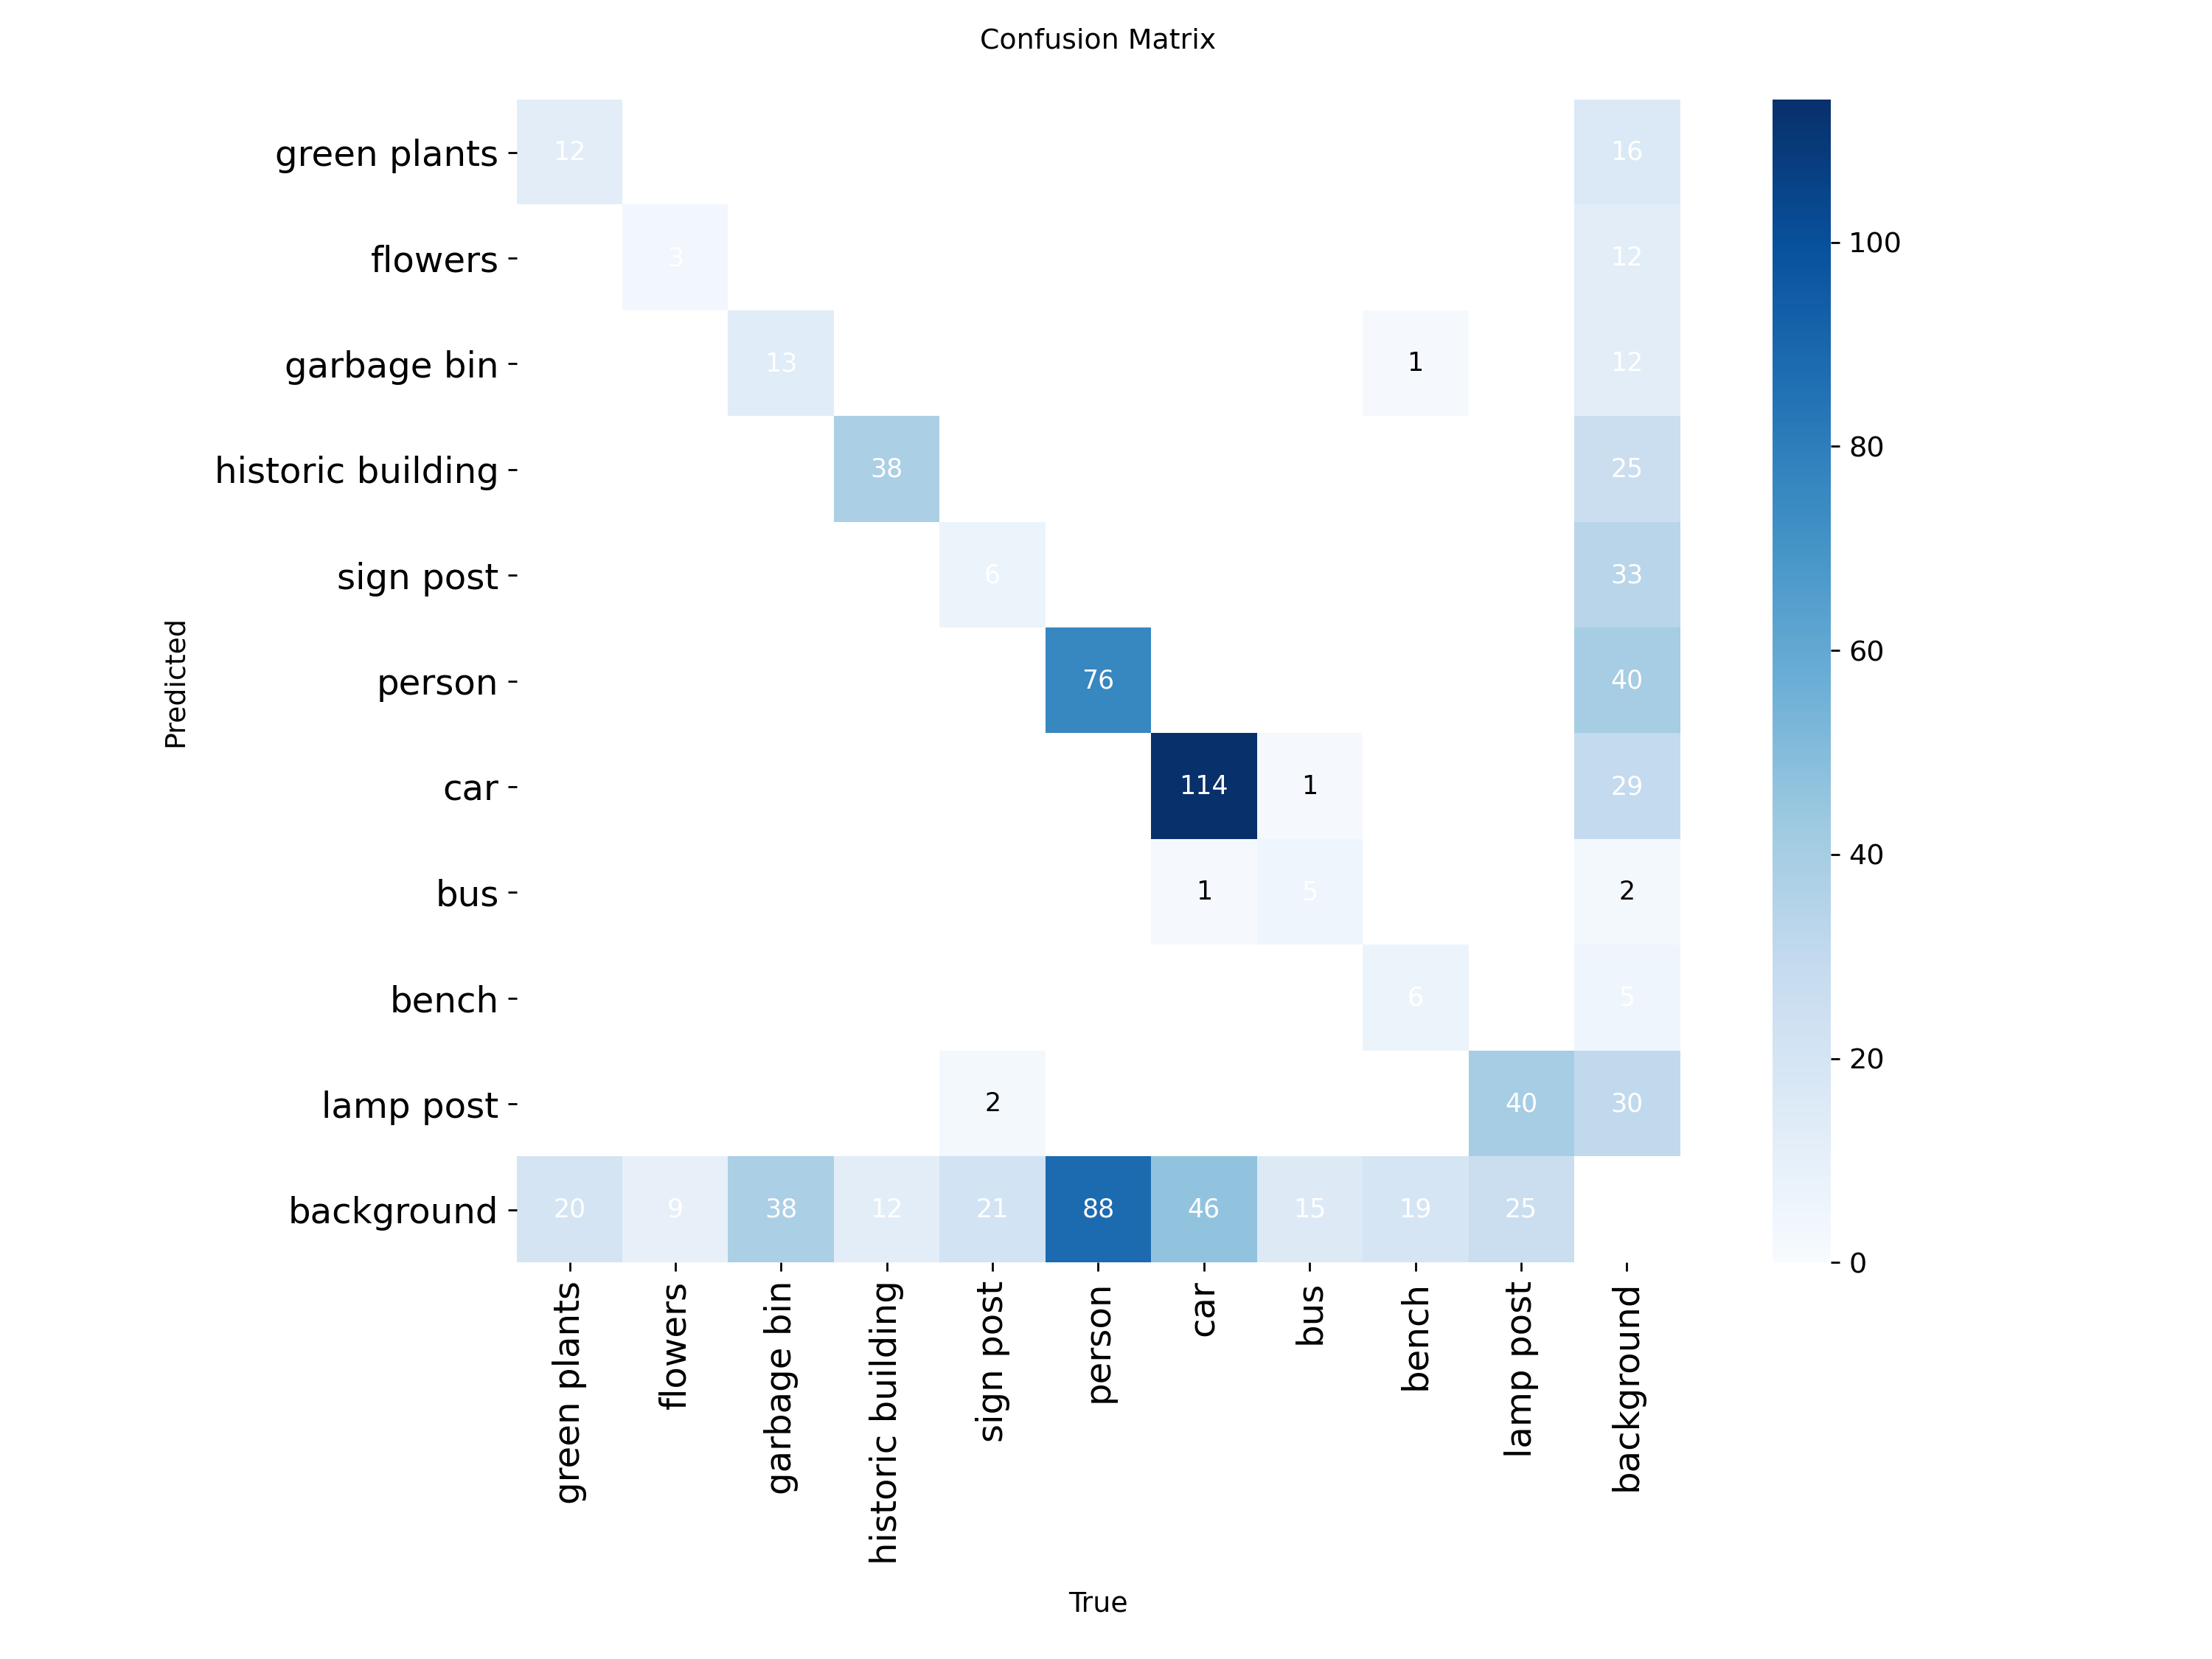


--- Trainings Metrieken (Loss, mAP, etc. over epochs) ---


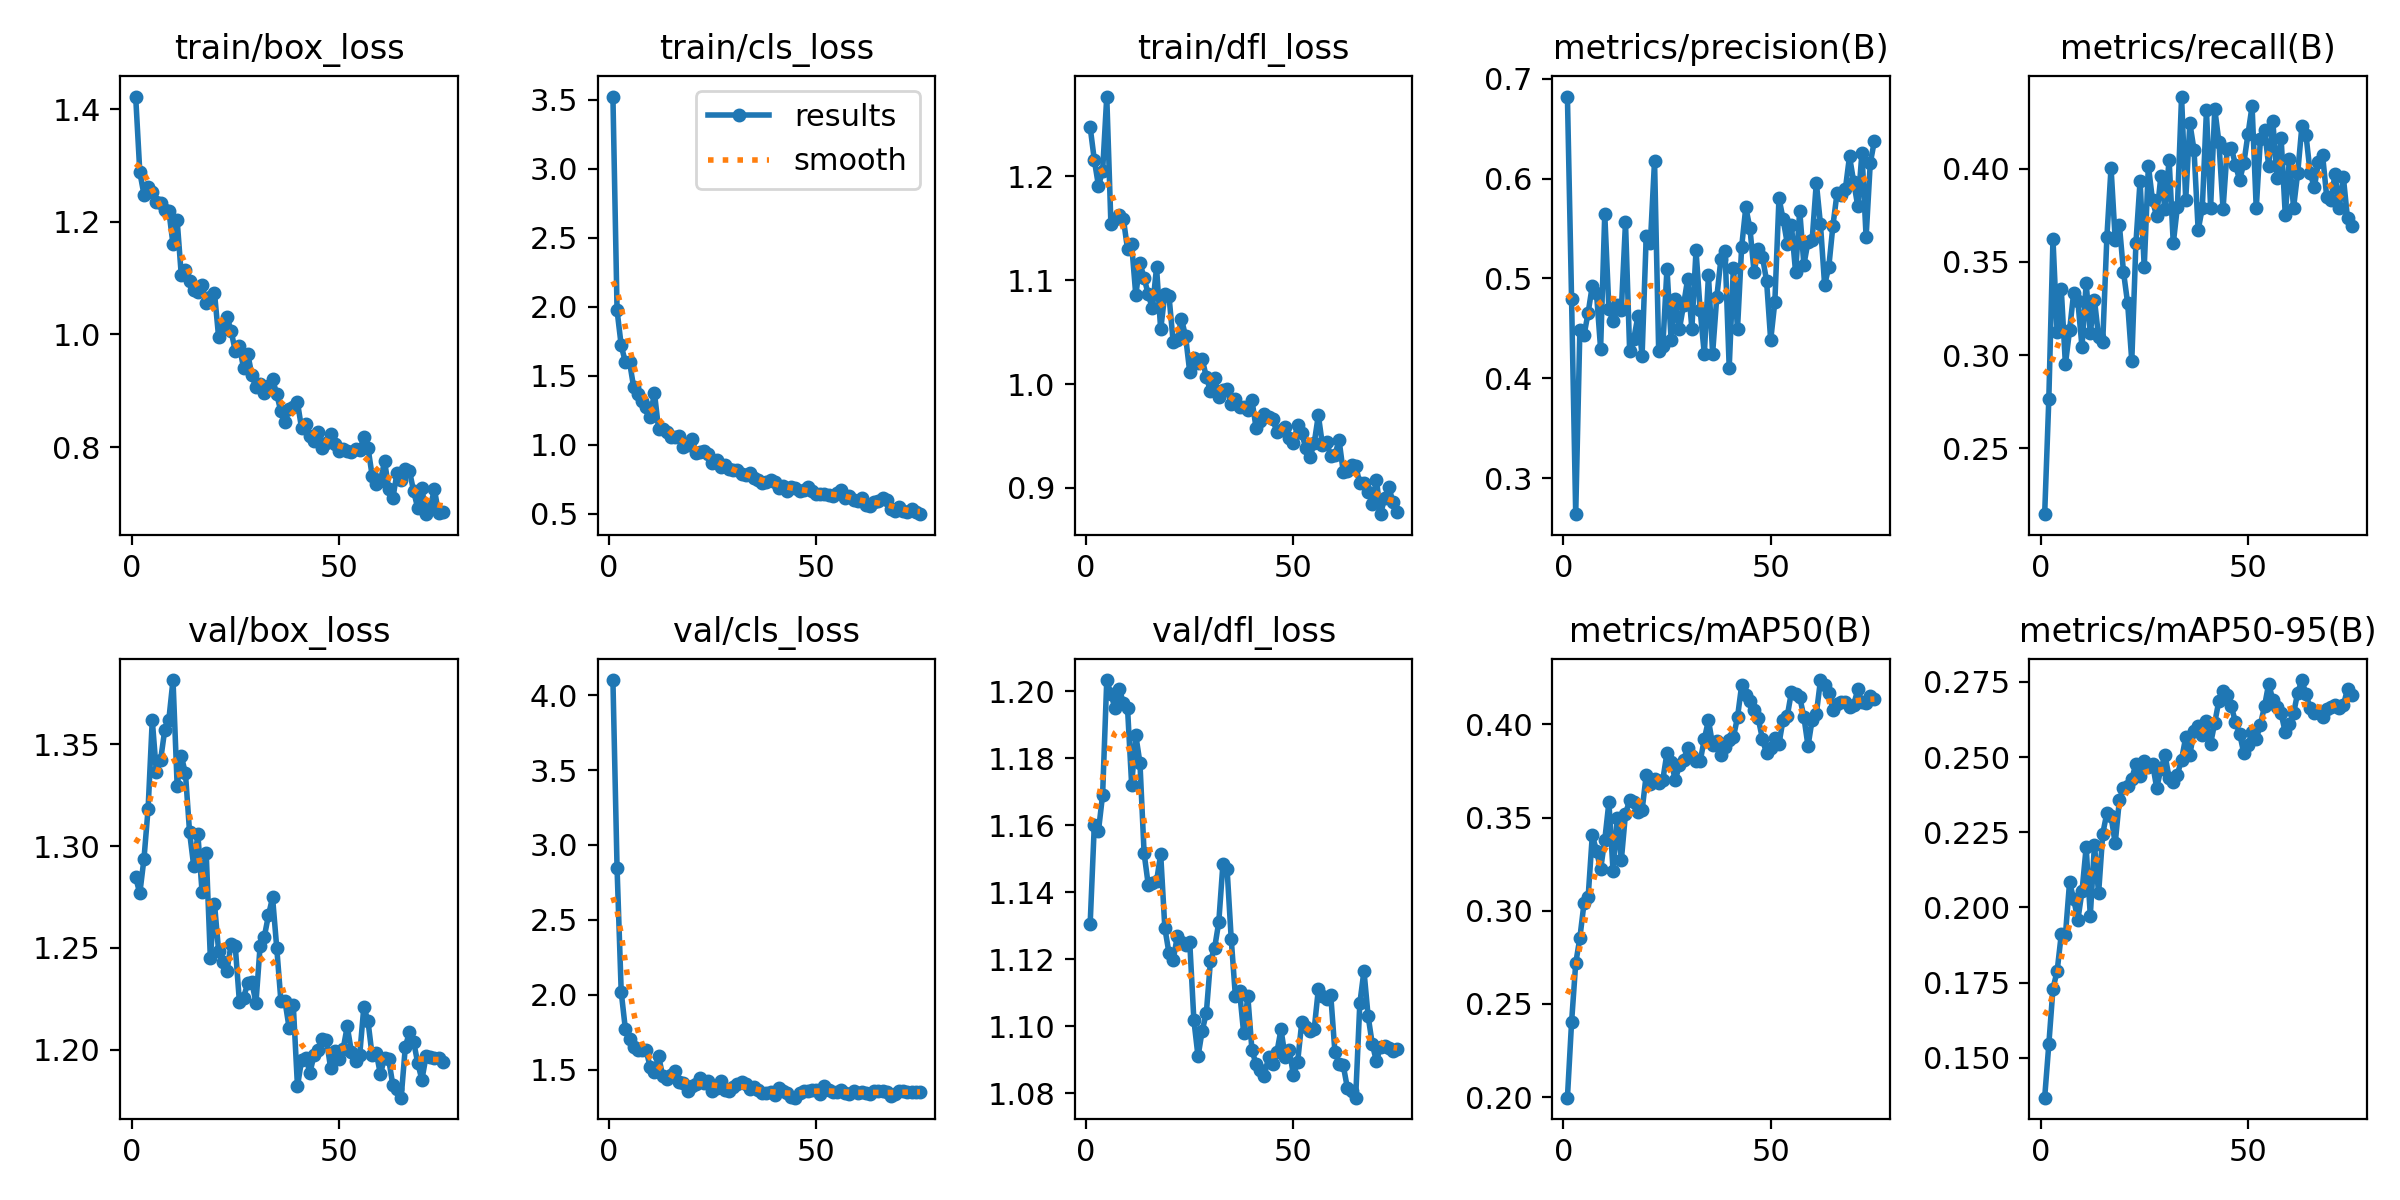


--- Voorbeeld Validatie Batch 0: Ground Truth Labels ---


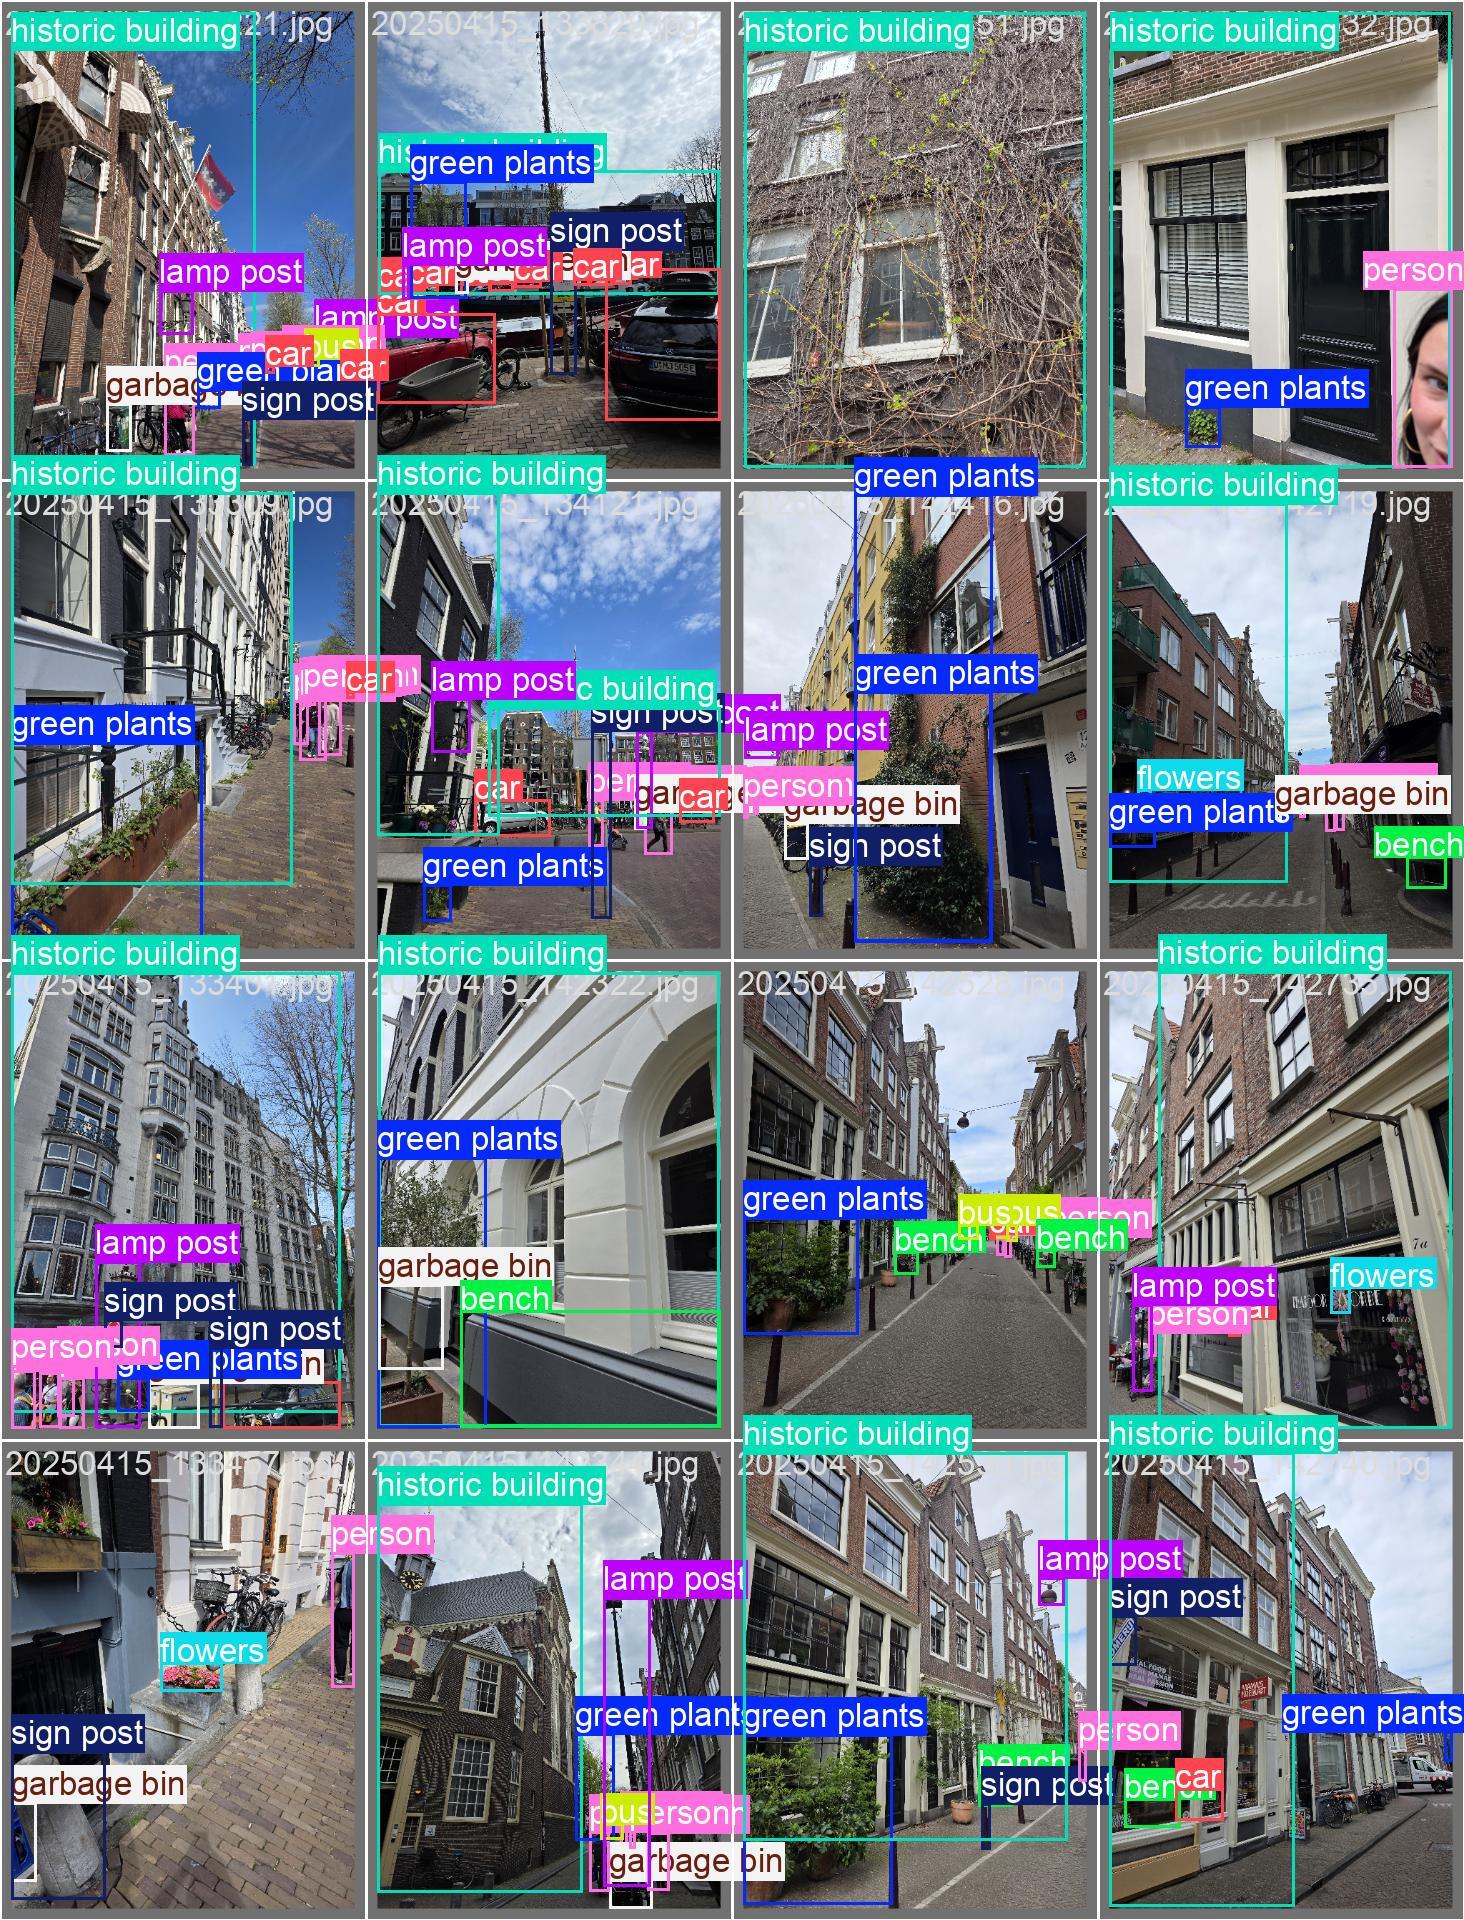


--- Voorbeeld Validatie Batch 0: Voorspellingen ---


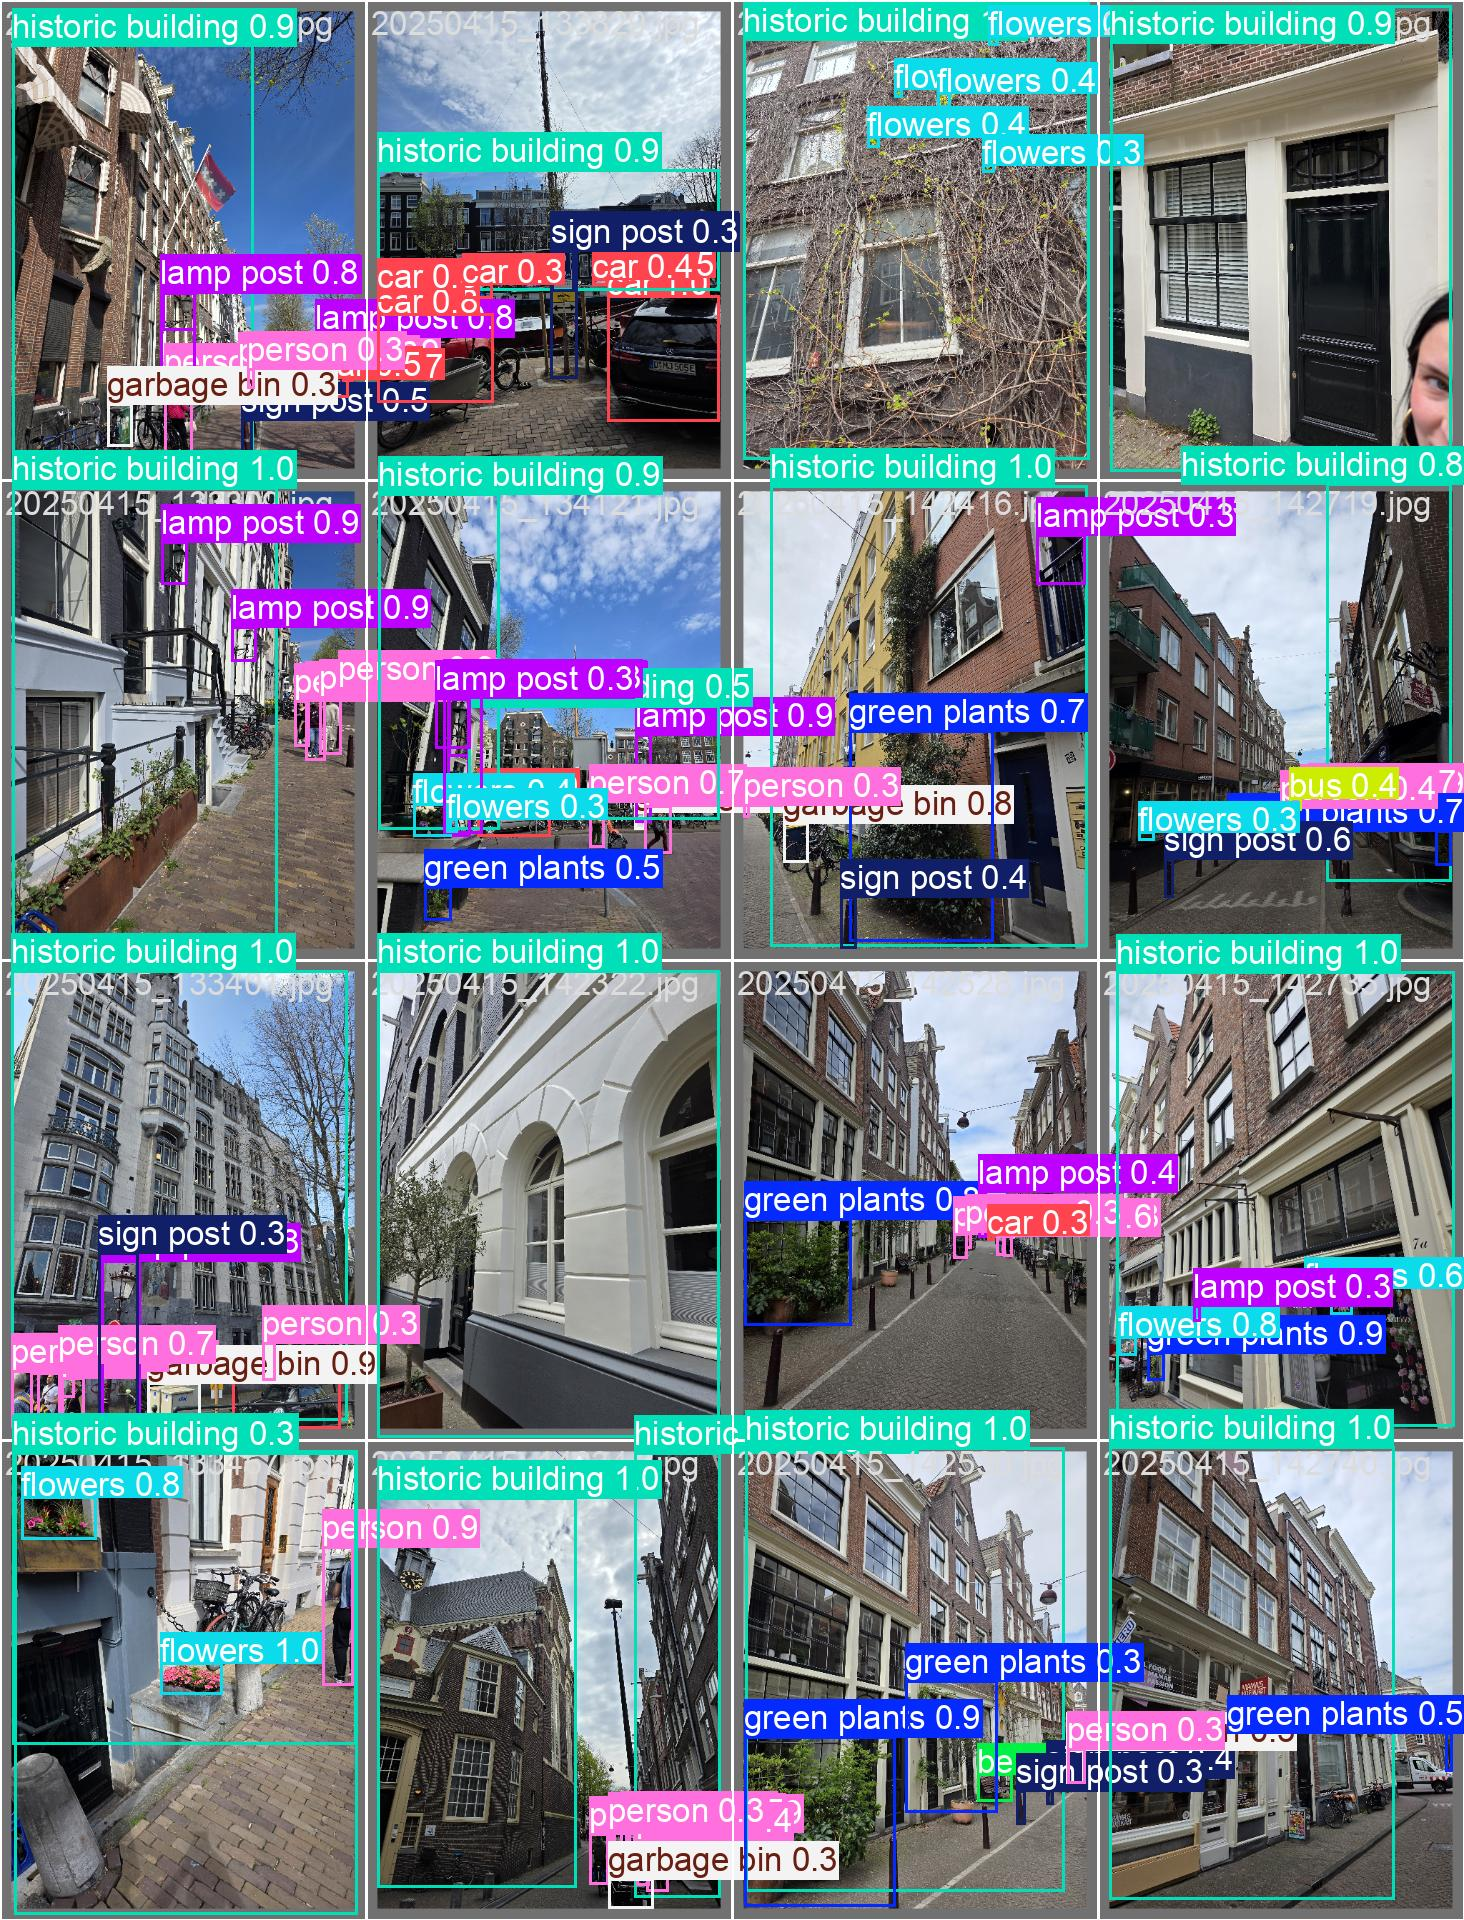


--- Finale Validatie Metrieken ---
Gedetailleerde metrieken niet direct beschikbaar in 'results' object. Raadpleeg de opgeslagen bestanden.


In [ ]:
# @title Stap 3.1: Toon Confusion Matrix en Trainingsresultaten
# Zorg ervoor dat LATEST_RUN_DIR correct is ingesteld door de vorige cel

if not LATEST_RUN_DIR or not os.path.isdir(LATEST_RUN_DIR):
    print("❌ FOUT: LATEST_RUN_DIR is niet (correct) ingesteld. Voer de training eerst uit.")
else:
    confusion_matrix_path = os.path.join(LATEST_RUN_DIR, 'confusion_matrix.png')
    results_graph_path = os.path.join(LATEST_RUN_DIR, 'results.png') # Grafiek met mAP, loss etc.
    val_batch0_labels_path = os.path.join(LATEST_RUN_DIR, 'val_batch0_labels.jpg') # GT voor eerste val batch
    val_batch0_pred_path = os.path.join(LATEST_RUN_DIR, 'val_batch0_pred.jpg') # Preds voor eerste val batch


    if os.path.exists(confusion_matrix_path):
        print("\n--- Confusion Matrix (Validatieset) ---")
        display(Image(filename=confusion_matrix_path))
    else:
        print(f"⚠️ Confusion matrix niet gevonden op {confusion_matrix_path}")

    if os.path.exists(results_graph_path):
        print("\n--- Trainings Metrieken (Loss, mAP, etc. over epochs) ---")
        display(Image(filename=results_graph_path))
    else:
        print(f"⚠️ Trainingsresultaten grafiek niet gevonden op {results_graph_path}")

    if os.path.exists(val_batch0_labels_path):
        print("\n--- Voorbeeld Validatie Batch 0: Ground Truth Labels ---")
        display(Image(filename=val_batch0_labels_path))
    else:
        print(f"⚠️ Voorbeeld Ground Truth (val_batch0_labels.jpg) niet gevonden.")

    if os.path.exists(val_batch0_pred_path):
        print("\n--- Voorbeeld Validatie Batch 0: Voorspellingen ---")
        display(Image(filename=val_batch0_pred_path))
    else:
        print(f"⚠️ Voorbeeld Voorspellingen (val_batch0_pred.jpg) niet gevonden.")

    # Print de finale metrieken van de validatie (opgeslagen in results object)
    print("\n--- Finale Validatie Metrieken ---")
    if results and hasattr(results, 'metrics'):
        print(f"  mAP50-95 (box): {results.metrics.box.map:.4f}")
        print(f"  mAP50 (box):   {results.metrics.box.map50:.4f}")
        print(f"  mAP75 (box):   {results.metrics.box.map75:.4f}")
        # Precision en Recall (box) zijn ook beschikbaar in results.metrics.box.p en .r (vaak arrays)
        # Voor een enkele waarde, kijk naar de laatst gerapporteerde of die van de beste epoch.
        # results.csv in de run directory heeft gedetailleerde per-epoch data.
    else:
        print("Gedetailleerde metrieken niet direct beschikbaar in 'results' object. Raadpleeg de opgeslagen bestanden.")


Laden van beste model: runs/detect/yolov8_amsterdam_sfeer_v17/weights/best.pt

--- Evalueren op de Test Set ---
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3932.1±1523.8 MB/s, size: 8018.8 KB)


val: Scanning /content/groundingdino_yolo_dataset/labels/test.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

val: /content/groundingdino_yolo_dataset/images/test/20250415_133243.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/images/test/20250415_133354.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/images/test/20250415_142210.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/images/test/20250415_142237.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/images/test/20250415_142407.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/images/test/20250415_142836.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/images/test/20250415_143144.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/images/test/20250415_143215.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/images/test/20250415_143243.jpg: corrupt JPEG restored and saved
val: /content/groundingdino_yolo_dataset/image


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


                   all         30        339       0.65      0.408      0.455      0.302
          green plants         14         15      0.686      0.333      0.446      0.261
               flowers          5          7      0.532      0.714      0.615      0.346
           garbage bin         20         24      0.606      0.193      0.202      0.139
     historic building         25         29      0.739      0.621      0.768      0.663
             sign post         11         13      0.217      0.154      0.141     0.0924
                person         18        120      0.769      0.483       0.62      0.343
                   car         24         76      0.771      0.671      0.717      0.515
                   bus          8          9      0.522      0.333      0.406      0.261
                 bench          9         12          1          0     0.0559     0.0264
             lamp post         23         34      0.662      0.577      0.583      0.369
Speed: 2.5ms preproce

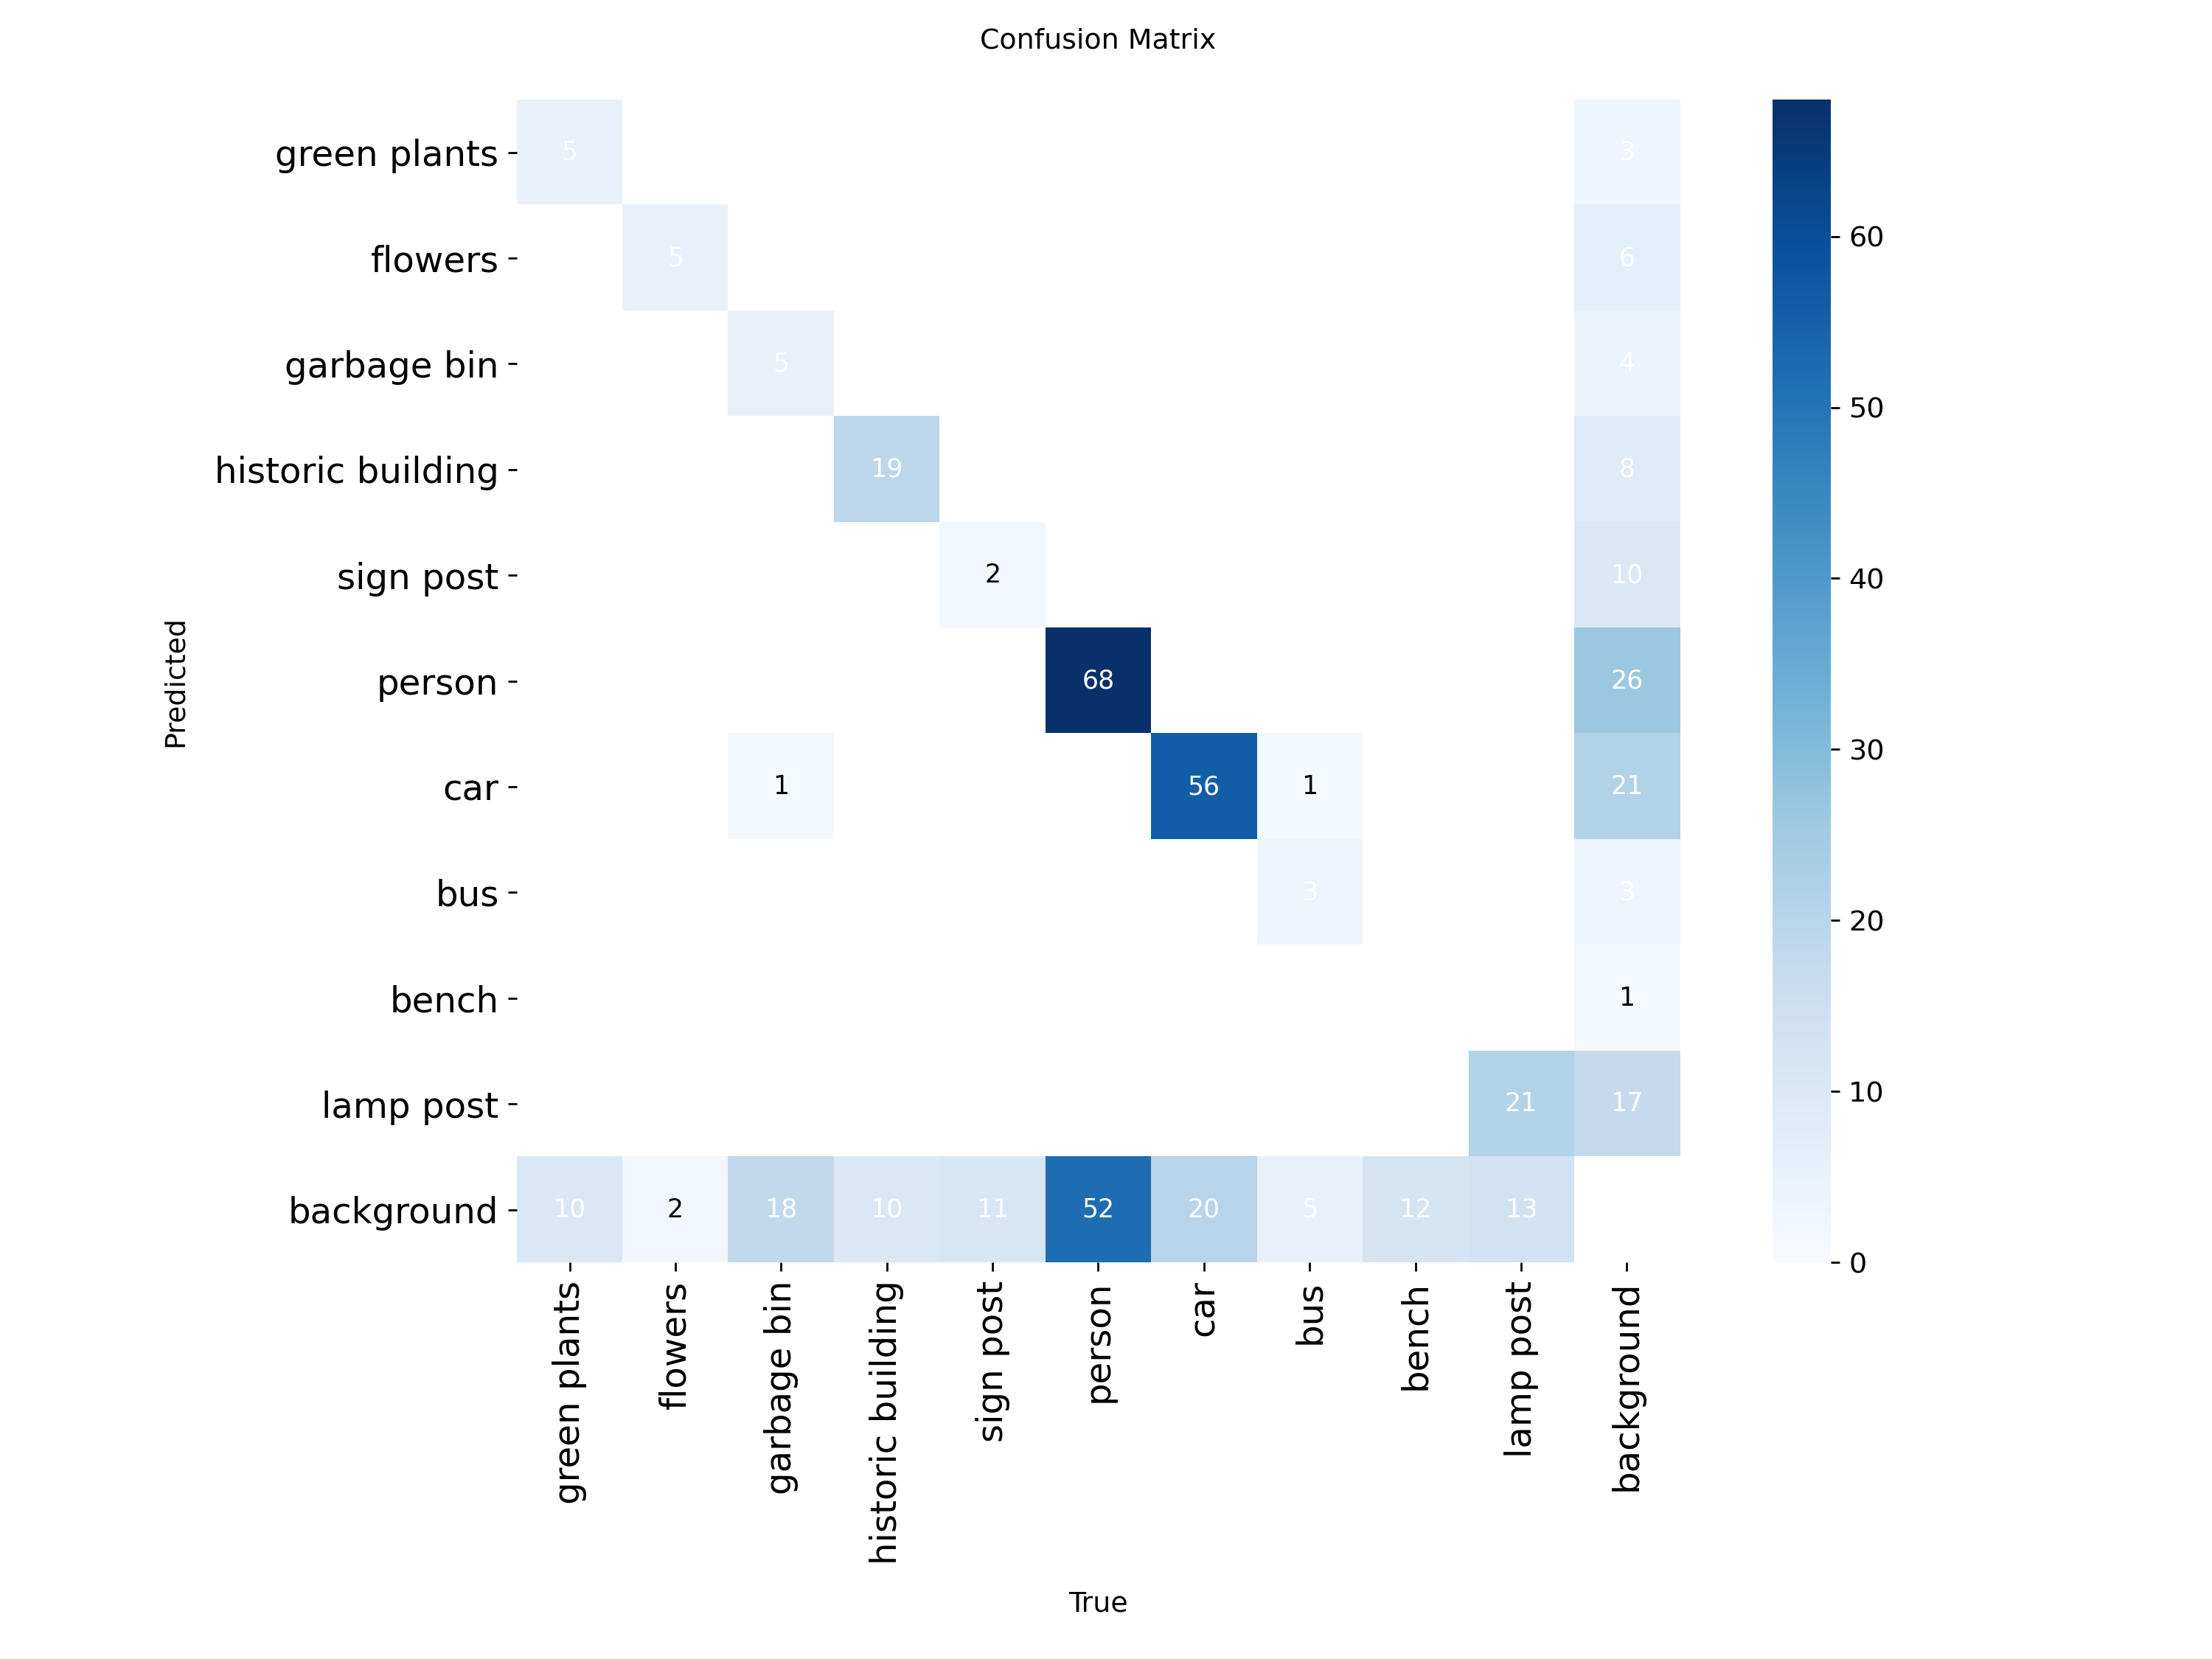

In [ ]:
# @title Stap 3.2: Evalueer op de Test Set (indien aanwezig)
# Zorg ervoor dat LATEST_RUN_DIR en data_config correct zijn ingesteld

if not LATEST_RUN_DIR or not os.path.isdir(LATEST_RUN_DIR):
    print("❌ FOUT: LATEST_RUN_DIR is niet (correct) ingesteld. Voer de training eerst uit.")
elif 'test' not in data_config or not data_config['test']:
    print("\nℹ️ Geen 'test' set gespecificeerd in data.yaml. Overslaan van testset evaluatie.")
else:
    path_to_best_weights = os.path.join(LATEST_RUN_DIR, 'weights/best.pt')
    if not os.path.exists(path_to_best_weights):
        print(f"❌ FOUT: Beste gewichten (best.pt) niet gevonden in {LATEST_RUN_DIR}/weights/")
    else:
        print(f"\nLaden van beste model: {path_to_best_weights}")
        model_best = YOLO(path_to_best_weights)

        print("\n--- Evalueren op de Test Set ---")
        # De .val() methode wordt gebruikt voor evaluatie.
        # Het slaat resultaten op in de directory van het model (LATEST_RUN_DIR)
        # onder een naam als 'val' of 'test_results' (afhankelijk van split)
        try:
            test_metrics = model_best.val(data=DATA_YAML_PATH, split='test', save_json=True, save_hybrid=True)
            # save_json=True slaat COCO-formaat JSON op, save_hybrid slaat YOLO-txt met confidences op
            print("\nTest Set Metrieken:")
            print(f"  mAP50-95 (box): {test_metrics.box.map:.4f}")
            print(f"  mAP50 (box):   {test_metrics.box.map50:.4f}")
            print(f"  mAP75 (box):   {test_metrics.box.map75:.4f}")

            # Zoek de confusion matrix voor de test set (YOLOv8 slaat dit soms op na .val())
            # De naam kan variëren, vaak in een submap van de run.
            # Als .val() een nieuwe runmap maakt, moet je daar zoeken.
            # Check LATEST_RUN_DIR voor een nieuwe confusion matrix specifiek voor 'test'.
            # Of de output van test_metrics.save_dir als dat beschikbaar is.
            test_run_save_dir = test_metrics.save_dir # Dit is de map waar de test resultaten zijn opgeslagen
            test_confusion_matrix_path = os.path.join(test_run_save_dir, 'confusion_matrix.png')

            if os.path.exists(test_confusion_matrix_path):
                print("\n--- Confusion Matrix (Testset) ---")
                display(Image(filename=test_confusion_matrix_path))
            else:
                print(f"⚠️ Confusion matrix voor testset niet direct gevonden in {test_run_save_dir}. Kan elders zijn opgeslagen.")

        except Exception as e:
            print(f"❌ Fout tijdens evaluatie op testset: {e}")
            print("  Zorg ervoor dat de 'test' paden in data.yaml correct zijn en de afbeeldingen/labels bestaan.")

In [ ]:
# @title Stap 4.1: Voorspellingen doen met getraind model en tabel genereren
# Zorg ervoor dat LATEST_RUN_DIR en data_config correct zijn ingesteld

# Placeholder functie voor GPS - DEZE MOET JE ZELF IMPLEMENTEREN
def get_gps_for_filename(filename, image_dir_path):
    """
    Placeholder/Voorbeeld functie om GPS data te krijgen.
    Je moet dit aanpassen om daadwerkelijk GPS data te lezen (EXIF, lookup tabel, etc.)
    """
    # Voorbeeld: probeer EXIF te lezen (vereist Pillow)
    try:
        from PIL import Image as PILImage
        from PIL.ExifTags import GPSTAGS, TAGS

        full_image_path = os.path.join(image_dir_path, filename)
        pil_image = PILImage.open(full_image_path)
        exif_data = pil_image._getexif()

        if exif_data:
            gps_info = {}
            for k, v in exif_data.items():
                decode = GPSTAGS.get(k, k)
                gps_info[decode] = v

            if 'GPSInfo' in gps_info: # Soms is GPSInfo direct onder exif_data
                 gps_data_raw = gps_info['GPSInfo']
            elif 34853 in exif_data: # Check by raw GPS IFD tag
                 gps_data_raw = exif_data[34853]
            else:
                # print(f"Geen GPSInfo tag gevonden voor {filename}")
                return "N/A", "N/A"

            # Check of de benodigde GPS keys bestaan
            if 2 in gps_data_raw and 4 in gps_data_raw and 1 in gps_data_raw and 3 in gps_data_raw:
                lat_deg = gps_data_raw[2][0]
                lat_min = gps_data_raw[2][1]
                lat_sec = gps_data_raw[2][2]
                lat_ref = gps_data_raw[1]

                lon_deg = gps_data_raw[4][0]
                lon_min = gps_data_raw[4][1]
                lon_sec = gps_data_raw[4][2]
                lon_ref = gps_data_raw[3]

                lat = (lat_deg + (lat_min / 60) + (lat_sec / 3600)) * (-1 if lat_ref == 'S' else 1)
                lon = (lon_deg + (lon_min / 60) + (lon_sec / 3600)) * (-1 if lon_ref == 'W' else 1)
                return f"{lat:.6f}", f"{lon:.6f}"
            else:
                # print(f"Onvolledige GPS data keys voor {filename}")
                return "N/A", "N/A"
    except ImportError:
        # print("Pillow is niet geïnstalleerd. Kan EXIF niet lezen.")
        pass # Val terug naar N/A als Pillow niet beschikbaar is
    except Exception as e:
        # print(f"Fout bij lezen EXIF voor {filename}: {e}")
        pass # Val terug naar N/A bij andere EXIF fouten
    return "N/A", "N/A"


if not LATEST_RUN_DIR or not os.path.isdir(LATEST_RUN_DIR):
    print("❌ FOUT: LATEST_RUN_DIR is niet (correct) ingesteld. Voer de training eerst uit.")
else:
    path_to_best_weights = os.path.join(LATEST_RUN_DIR, 'weights/best.pt')
    if not os.path.exists(path_to_best_weights):
        print(f"❌ FOUT: Beste gewichten (best.pt) niet gevonden in {LATEST_RUN_DIR}/weights/")
    else:
        print(f"\nLaden van beste getrainde model: {path_to_best_weights}")
        yolo_model_trained = YOLO(path_to_best_weights)

        # Bepaal op welke set afbeeldingen je voorspellingen wilt doen (bv. test set)
        target_split_for_prediction = 'test' # Kan ook 'val' of 'train' zijn
        prediction_image_paths = []
        prediction_image_dir_abs = ""

        if target_split_for_prediction in data_config and data_config[target_split_for_prediction]:
            # data_config['path'] is de absolute root, data_config['test'] is relatief (bv. 'images/test')
            # We moeten het absolute pad naar de images in de split reconstrueren
            # Het 'path' in data_config is al absoluut gemaakt in stap 2.2
            # De split paden (train, val, test) zijn relatief t.o.v. dit absolute pad.
            relative_image_dir_for_split = data_config[target_split_for_prediction]
            # Check of het pad al 'images/' bevat, anders voeg toe.
            if not relative_image_dir_for_split.startswith('images/'):
                 # Dit zou niet moeten gebeuren met de standaard YOLO data.yaml structuur.
                 # Maar voor de zekerheid:
                 print(f"Warning: Pad voor split '{target_split_for_prediction}' ({relative_image_dir_for_split}) lijkt niet standaard. Probeer toch...")

            prediction_image_dir_abs = os.path.join(data_config['path'], relative_image_dir_for_split)

            if os.path.isdir(prediction_image_dir_abs):
                print(f"Afbeeldingen voor voorspelling uit: {prediction_image_dir_abs}")
                for img_name in os.listdir(prediction_image_dir_abs):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        prediction_image_paths.append(os.path.join(prediction_image_dir_abs, img_name))
                if not prediction_image_paths:
                    print(f"⚠️ Geen afbeeldingen gevonden in {prediction_image_dir_abs}")
            else:
                print(f"❌ Afbeeldingsdirectory voor voorspelling niet gevonden: {prediction_image_dir_abs}")
        else:
            print(f"ℹ️ Geen '{target_split_for_prediction}' set gedefinieerd in data.yaml of pad is leeg. Kan geen voorspellingen doen op deze set.")


        all_predictions_for_table = []
        if prediction_image_paths:
            print(f"\n--- Voorspellingen doen op {len(prediction_image_paths)} afbeeldingen uit de '{target_split_for_prediction}' set ---")
            # Gebruik de absolute directory van de afbeeldingen voor de GPS functie
            current_image_set_dir_for_gps = prediction_image_dir_abs

            for img_path_abs in tqdm(prediction_image_paths, desc="Voorspellen"):
                filename = os.path.basename(img_path_abs)

                # Haal GPS data op
                # Stuur het absolute pad naar de map mee, zodat get_gps_for_filename de afbeelding kan vinden
                gps_lat, gps_lon = get_gps_for_filename(filename, current_image_set_dir_for_gps)

                # Doe voorspelling. conf=0.25 is een voorbeeld, pas aan indien nodig.
                results_pred_list = yolo_model_trained.predict(source=img_path_abs, conf=0.25, verbose=False)

                for res_pred in results_pred_list: # results_pred is een lijst (meestal met 1 element)
                    boxes = res_pred.boxes
                    for box in boxes:
                        class_id = int(box.cls)
                        category_name = yolo_model_trained.names[class_id] # Haal naam op uit model
                        confidence = float(box.conf)
                        xyxy = box.xyxy[0].cpu().numpy()
                        x_min, y_min, x_max, y_max = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])
                        width = x_max - x_min
                        height = y_max - y_min

                        all_predictions_for_table.append({
                            'image_filename': filename,
                            'gps_latitude': gps_lat,
                            'gps_longitude': gps_lon,
                            'detection_method': f'YOLOv8_{MODEL_VARIANT.split(".")[0]}', # bv. YOLOv8_yolov8s
                            'object_category': category_name,
                            'bbox_x_min': x_min,
                            'bbox_y_min': y_min,
                            'bbox_width': width,
                            'bbox_height': height,
                            'confidence_score': round(confidence, 4)
                        })

            # Maak DataFrame en sla op
            df_predictions = pd.DataFrame(all_predictions_for_table)
            output_csv_yolo_results = os.path.join(LATEST_RUN_DIR, f"yolov8_custom_predictions_{target_split_for_prediction}_set.csv")
            df_predictions.to_csv(output_csv_yolo_results, index=False)

            print(f"\n✅ YOLOv8 voorspellingen op '{target_split_for_prediction}' set opgeslagen in: {output_csv_yolo_results}")
            if not df_predictions.empty:
                print("\nEerste 5 voorspellingen:")
                print(df_predictions.head().to_string())
            else:
                print("ℹ️ Geen voorspellingen gemaakt of opgenomen in de tabel.")
        else:
            print(f"ℹ️ Geen afbeeldingen om voorspellingen op te doen voor de '{target_split_for_prediction}' set.")


Laden van beste getrainde model: runs/detect/yolov8_amsterdam_sfeer_v17/weights/best.pt
Afbeeldingen voor voorspelling uit: /content/groundingdino_yolo_dataset/images/test

--- Voorspellingen doen op 30 afbeeldingen uit de 'test' set ---


Voorspellen:   0%|          | 0/30 [00:00<?, ?it/s]


✅ YOLOv8 voorspellingen op 'test' set opgeslagen in: runs/detect/yolov8_amsterdam_sfeer_v17/yolov8_custom_predictions_test_set.csv

Eerste 5 voorspellingen:
               image_filename gps_latitude gps_longitude detection_method    object_category  bbox_x_min  bbox_y_min  bbox_width  bbox_height  confidence_score
0  PXL_20250416_132531297.jpg          N/A           N/A   YOLOv8_yolov8s  historic building           0        1266        2268         1102            0.9658
1  PXL_20250416_132531297.jpg          N/A           N/A   YOLOv8_yolov8s          lamp post        1364        2088          46          229            0.4055
2         20250415_143144.jpg          N/A           N/A   YOLOv8_yolov8s          sign post        1007        1526          73          599            0.7633
3         20250415_143144.jpg          N/A           N/A   YOLOv8_yolov8s            flowers        1748        2255         133          110            0.7433
4         20250415_143144.jpg          N/A

In [ ]:
# Compress the /content folder (excluding unnecessary files if needed)
# -r: recursive
# -q: quiet (less output)
# -x exclude: specify patterns to exclude (e.g., *.ipynb for notebooks, *.pth for large models if not needed)
!zip -r -q /content.zip /content/ -x "*.ipynb_checkpoints/*" "*/.ipynb_checkpoints/*"

# Download the zip file
from google.colab import files
files.download('/content.zip')

zip warning: Operation not supported
zip warning: Operation not supported
zip warning: Operation not supported
zip warning: Operation not supported
zip warning: Operation not supported
zip warning: Operation not supported
zip warning: Operation not supported
zip warning: Operation not supported
zip warning: Operation not supported
zip warning: Operation not supported


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title 1. Setup: Installaties en Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog # Voor HOG features
from skimage import exposure
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import random
import pickle # Om getrainde modellen op te slaan/laden
from tqdm.notebook import tqdm
import pandas as pd # Voor de output tabel

# Helper functie om afbeeldingen te tonen
def plot_image(image, title="Image", cmap=None):
    plt.figure(figsize=(8, 6))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

print("✅ Setup voltooid.")

✅ Setup voltooid.


In [ ]:
# @title 2. Configuratie en Pad-instellingen
# ----- Pad naar je dataset (dezelfde als voor YOLO) -----
# We hebben de afbeeldingen nodig, en idealiter ook de (gecorrigeerde) YOLO labels
# om positieve en negatieve samples te kunnen extraheren.
BASE_DATASET_DIR = '/content/groundingdino_yolo_dataset' # Root van je dataset (waar 'images' en 'labels' in staan)
IMAGE_DIR_TRAIN = os.path.join(BASE_DATASET_DIR, 'images/train')
LABEL_DIR_TRAIN = os.path.join(BASE_DATASET_DIR, 'labels/train')
IMAGE_DIR_VAL = os.path.join(BASE_DATASET_DIR, 'images/val') # Of gebruik de testset voor evaluatie klassiek model
LABEL_DIR_VAL = os.path.join(BASE_DATASET_DIR, 'labels/val')
IMAGE_DIR_TEST = os.path.join(BASE_DATASET_DIR, 'images/test') # Voor de finale tabel
LABEL_DIR_TEST = os.path.join(BASE_DATASET_DIR, 'labels/test')


# ----- Categorieën die we klassiek gaan proberen te detecteren -----
# We beginnen met 'person'
CLASS_NAME_PERSON = "person" # Moet exact overeenkomen met naam in je data.yaml
CLASS_ID_PERSON = None # Wordt opgezocht in data.yaml

# Zoek de class ID voor 'person' uit de data.yaml (als die nog niet geladen is)
# Dit is nodig om de juiste objecten uit de YOLO label files te halen
DATA_YAML_PATH = os.path.join(BASE_DATASET_DIR, 'data.yaml')
if os.path.exists(DATA_YAML_PATH):
    import yaml
    with open(DATA_YAML_PATH, 'r') as f:
        data_config = yaml.safe_load(f)
    CLASS_NAMES_FROM_YAML = data_config.get('names', {})
    for cid, cname in CLASS_NAMES_FROM_YAML.items():
        if cname == CLASS_NAME_PERSON:
            CLASS_ID_PERSON = cid
            break
    if CLASS_ID_PERSON is not None:
        print(f"✅ Klasse '{CLASS_NAME_PERSON}' gevonden met ID: {CLASS_ID_PERSON}")
    else:
        print(f"⚠️ FOUT: Klasse '{CLASS_NAME_PERSON}' niet gevonden in {DATA_YAML_PATH}. Controleer de naam.")
        # Stop of handel af als de klasse niet gevonden wordt.
else:
    print(f"⚠️ FOUT: {DATA_YAML_PATH} niet gevonden. Kan class ID niet bepalen.")
    # Handmatige fallback (minder ideaal):
    # CLASS_ID_PERSON = 5 # Als je weet dat 'person' index 5 heeft

# --- HOG Parameters ---
# Deze waarden zijn gebruikelijk voor personendetectie en kunnen getuned worden
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8) # Moet overeenkomen met de grootte van de patches die je traint
HOG_CELLS_PER_BLOCK = (2, 2) # Normalisatieblokken
HOG_VISUALIZE = False
HOG_FEATURE_VECTOR = True # hog() retourneert een feature vector ipv een HOG image

# --- SVM Parameters ---
SVM_MODEL_PATH_PERSON = f"classic_svm_person_model.pkl"
SCALER_PATH_PERSON = f"classic_scaler_person_model.pkl"

# --- Sliding Window Parameters (voor detectie fase) ---
# Definieer de standaard grootte van je detectie window (moet overeenkomen met HOG training)
# Voor personen is dit vaak een vaste aspect ratio, bv. 64x128 pixels
BASE_WINDOW_SIZE = (64, 128) # (width, height)
DOWNSCALE_FACTOR = 1.25 # Hoeveel kleiner wordt de afbeelding bij elke schaalstap
STEP_SIZE_WINDOW = (int(BASE_WINDOW_SIZE[0] * 0.2), int(BASE_WINDOW_SIZE[1] * 0.2)) # Overlap

# --- Output Tabel ---
CLASSIC_PREDICTIONS_CSV = "classic_method_predictions.csv"
all_classic_predictions = []


print(f"\nConfiguratie voor '{CLASS_NAME_PERSON}':")
print(f"  HOG Pixels per cell: {HOG_PIXELS_PER_CELL}")
print(f"  HOG Cells per block: {HOG_CELLS_PER_BLOCK}")
print(f"  Basis Window Grootte: {BASE_WINDOW_SIZE}")

✅ Klasse 'person' gevonden met ID: 5

Configuratie voor 'person':
  HOG Pixels per cell: (8, 8)
  HOG Cells per block: (2, 2)
  Basis Window Grootte: (64, 128)
